# Comparison of Regressors for Abalone Age Prediction

## Om datasettet
Datasettet Abalone inneholder eksemplarer av Abalone, som er en en type skalldyr. For å bestemme alderen på Abalone, må man skjære opp skallet og telle ringene på insiden pluss 1.5 år. Prosesyren er både tidkrevende og ødeleggende for eksemplaret. 

Formålet med datasettet er å kunne forutsi antall ringer som en Abalone har basert på fysiske målinger ved hjelp av maskinlæring. 

Datasettet inneholder 4177 observasjoner, med 8 features og en målkolonne med antall ringer. Variablene i datasettet numeriske (heltall eller flyttall) eller kategoriske.

### Datasettet inneholder:
- **Sex:** Kategorisk, Kjønnet til skalldyret
- **Length:** Flyttall, Den lengste lengden målt på skjellet målt i mm
- **Diameter:** Flyttall, Diameteren vinkelrett på lengden målt i mm
- **Height:** Flyttall, Høyde med kjøttet i skallet målt i mm
- **Whole weight:** Flyttall, Vekten av hele skalldyret målt i g
- **Shucked wheight:** Flyttall, Vekten av kjøttet målt i g
- **Viscera weight:** Flyttall, Vekten av innvoldene etter blødning målt i g
- **Shell weight:** Flyttall, Vekten av skallet etter det er tørket målt i g
- **Rings:** Heltall, Antall ringer i skallet. +1.5 år gir alderen på skalldyret

In [184]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import tensorflow as tf

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, get_scorer
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, cross_validate, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from tensorflow.keras.layers import Dropout, Dense, BatchNormalization, Input
from tensorflow.keras.models import Sequential
from scikeras.wrappers import KerasRegressor

## Preprosessering

In [64]:
columns = ["Sex", "Length", "Diameter", "Height", "Whole weight", "Shucked weight", "Viscera weight", "Shell weight", "Rings"]
dataset = pd.read_csv("abalone.data", header=None, names=columns)

encoder = OneHotEncoder(sparse_output=False, drop="first")
encoded = encoder.fit_transform(dataset[["Sex"]])
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(["Sex"]))
dataset = pd.concat([dataset.drop(columns=["Sex"]), encoded_df], axis=1)

dataset.head()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,Sex_I,Sex_M
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,0.0,1.0
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,0.0,1.0
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,0.0,0.0
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,0.0,1.0
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,1.0,0.0


Brukte OneHotEncoder for å gjøre variablen numerisk, slik at jeg kan bruke kolonnen "Sex" til å finne lineær sammenheng uten at modellene skal tolke kategoriene som rangerte tallverdier. Dette fører til at kolonnen blir splittet i to nye. Tre kolonner vil være unødvendig ettersom 0 i begge kolonner vil indikere det samme som om det hadde vært en tredje kolonne.

In [65]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Length          4177 non-null   float64
 1   Diameter        4177 non-null   float64
 2   Height          4177 non-null   float64
 3   Whole weight    4177 non-null   float64
 4   Shucked weight  4177 non-null   float64
 5   Viscera weight  4177 non-null   float64
 6   Shell weight    4177 non-null   float64
 7   Rings           4177 non-null   int64  
 8   Sex_I           4177 non-null   float64
 9   Sex_M           4177 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 326.5 KB


### Manglende verdier og duplikater

In [66]:
missing_values = int(dataset.isna().sum().sum())
duplicate_values = int(dataset.isna().sum().sum())
print(f"Antall manglende verdier i datasettet: {missing_values}")
print(f"Antall duplikat-rader: {duplicate_values}")

Antall manglende verdier i datasettet: 0
Antall duplikat-rader: 0


Jeg sjekket at dataen var slik som forventet for datasettet. Antall rader og kolonner er korrekt, det er ingen manglende verdier slik som det står i dokumentasjonen, og heller ingen duplikat-rader

### Klassefordeling

array([[<Axes: title={'center': 'Length'}>,
        <Axes: title={'center': 'Diameter'}>,
        <Axes: title={'center': 'Height'}>],
       [<Axes: title={'center': 'Whole weight'}>,
        <Axes: title={'center': 'Shucked weight'}>,
        <Axes: title={'center': 'Viscera weight'}>],
       [<Axes: title={'center': 'Shell weight'}>,
        <Axes: title={'center': 'Rings'}>,
        <Axes: title={'center': 'Sex_I'}>],
       [<Axes: title={'center': 'Sex_M'}>, <Axes: >, <Axes: >]],
      dtype=object)

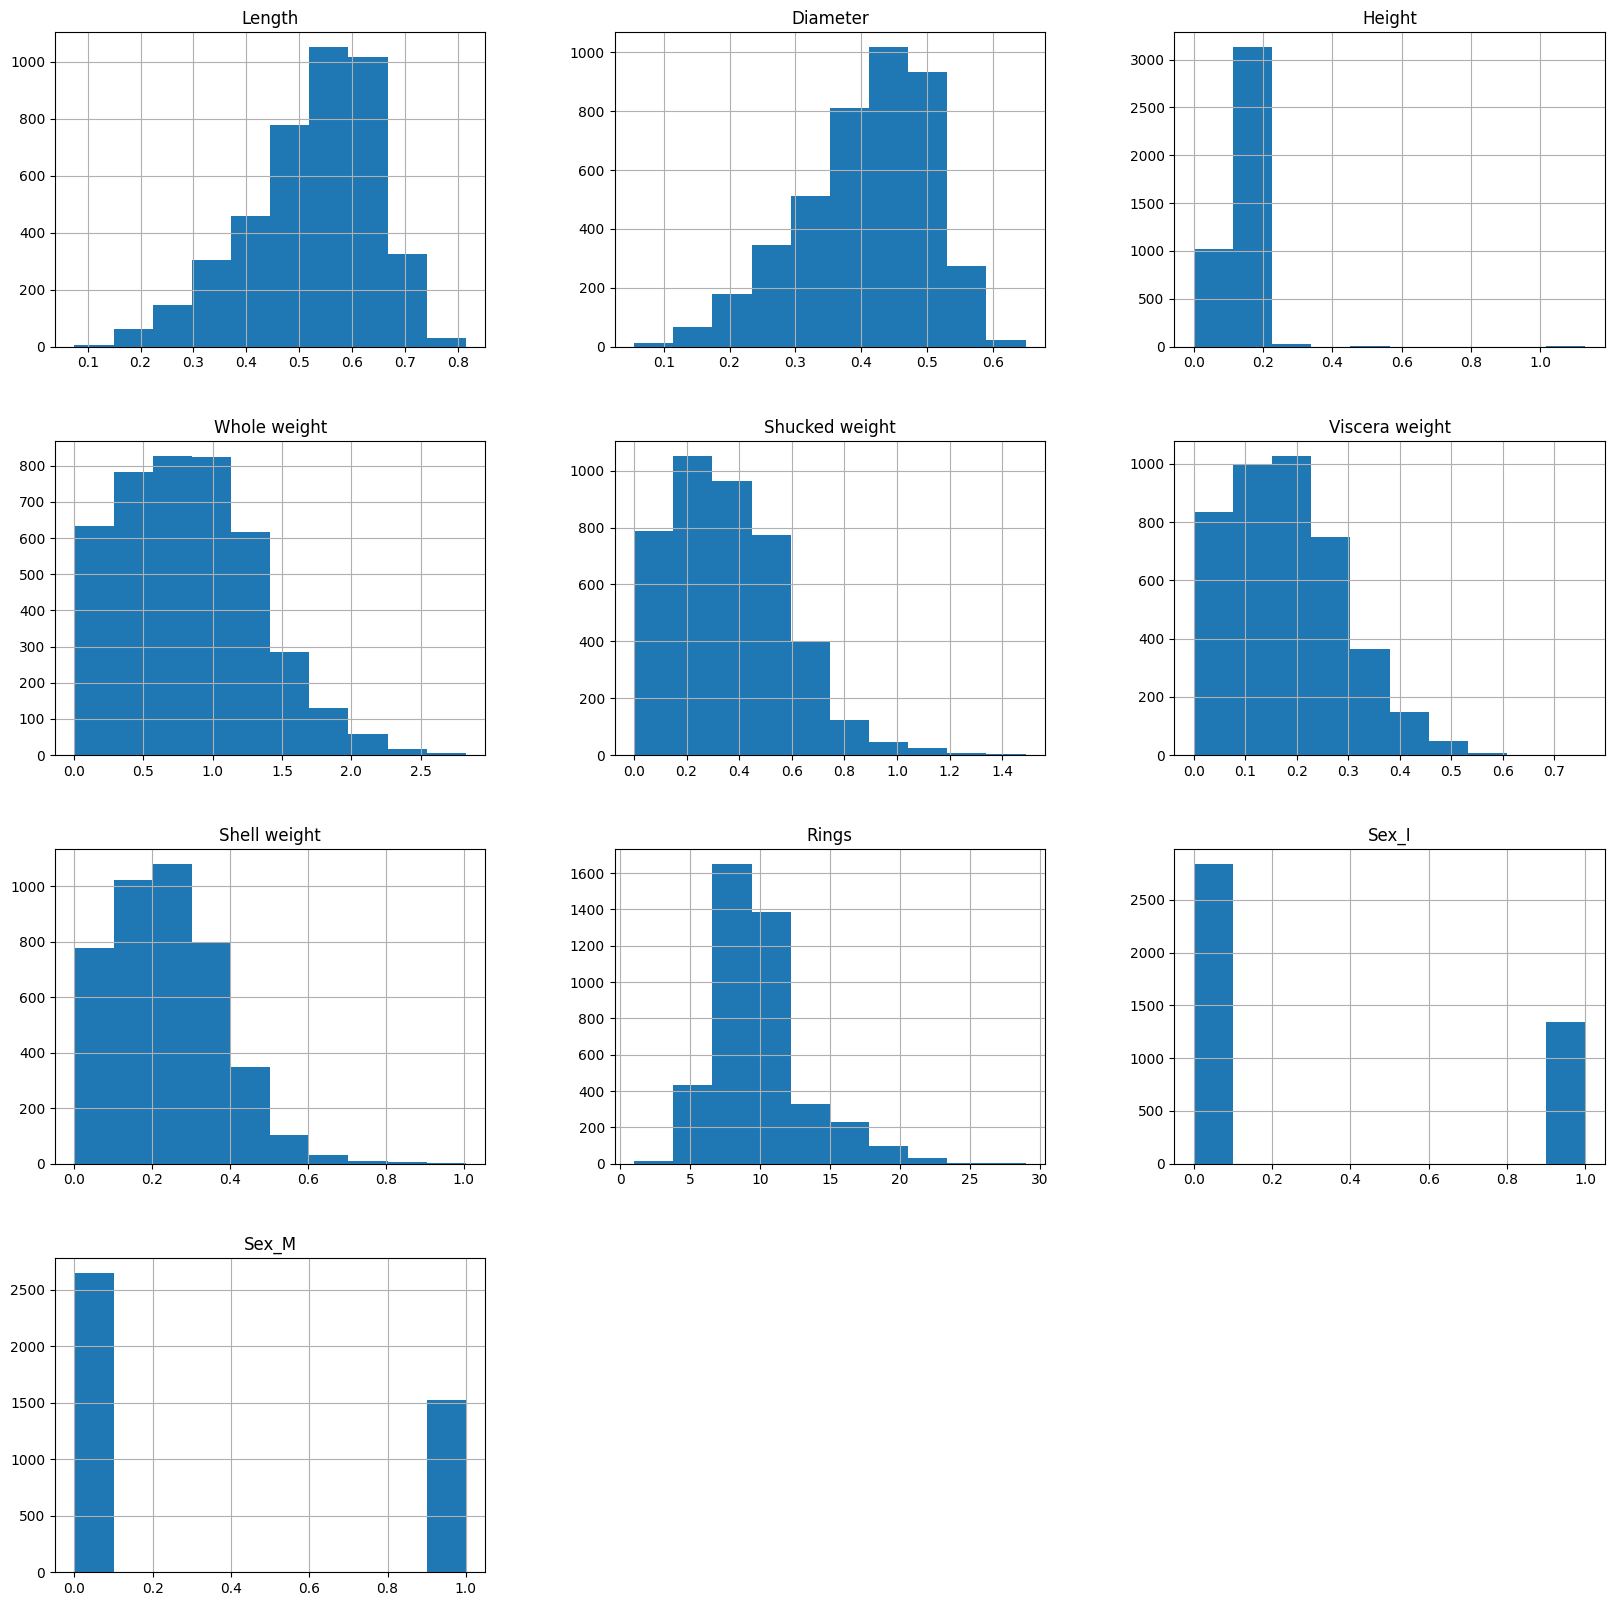

In [67]:
dataset_features = dataset.drop("Rings", axis=1)
dataset_targets = dataset["Rings"]
dataset.hist(figsize=(20,20))

In [68]:
dataset["Rings"].value_counts()

Rings
9     689
10    634
8     568
11    487
7     391
12    267
6     259
13    203
14    126
5     115
15    103
16     67
17     58
4      57
18     42
19     32
20     26
3      15
21     14
23      9
22      6
27      2
24      2
1       1
26      1
29      1
2       1
25      1
Name: count, dtype: int64

Datasettets målkolonne er litt høyeskjevt, men ikke så langt unna normalfordeling, med unntak av noen uteliggere. Feature verdiene er også relativt høyreskjeve, med unntak av Length og Diameter som er er litt venstreskjeve.

Ettersom noen features er høyreskjeve så vil jeg teste log-transformasjon av disse, nemlig på "Whole weight", "Shuckled weight", Viscera weight", "Shell weight" og "Height". "Length" og "Diameter" er kun moderat venstreskjeve, så disse beholder jeg som de er. "Sex_I" og "Sex_M" er binære, så her vil jeg heller ikke gjøre noen endring. Dette vil jeg kun gjøre på de lineære modellene, ettersom det ikke er hensiktsmessig å gjøre på de andre.

For målvariabelen vil jeg forsøke med log-transformasjoner for de lineære modellene, ettersom disse blir mest påvirket av en skjev fordeling.

For skalldyrene med 1, 2, 25, 26, og 29 ringer finnes det kun 1 observasjon. Om jeg skulle brukt klassifisering så ville det vært for lite til å gi informasjon til modellene, men ettersom det er regresjon så går det fint.

In [69]:
dataset.describe()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,Sex_I,Sex_M
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684,0.321283,0.365813
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169,0.467025,0.481715
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000,0.000000,0.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000,0.000000,0.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000,0.000000,0.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000,1.000000,1.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000,1.000000,1.000000


### Korrelasjon

In [70]:
categorical_features_correlation = dataset_features.corr()
categorical_features_correlation.style.background_gradient(cmap="coolwarm")

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Sex_I,Sex_M
Length,1.000000,0.986812,0.827554,0.925261,0.897914,0.903018,0.897706,-0.551465,0.236543
Diameter,0.986812,1.000000,0.833684,0.925452,0.893162,0.899724,0.905330,-0.564315,0.240376
Height,0.827554,0.833684,1.000000,0.819221,0.774972,0.798319,0.817338,-0.518552,0.215459
Whole weight,0.925261,0.925452,0.819221,1.000000,0.969405,0.966375,0.955355,-0.557592,0.252038
Shucked weight,0.897914,0.893162,0.774972,0.969405,1.000000,0.931961,0.882617,-0.521842,0.251793
Viscera weight,0.903018,0.899724,0.798319,0.966375,0.931961,1.000000,0.907656,-0.556081,0.242194
Shell weight,0.897706,0.905330,0.817338,0.955355,0.882617,0.907656,1.000000,-0.546953,0.235391
Sex_I,-0.551465,-0.564315,-0.518552,-0.557592,-0.521842,-0.556081,-0.546953,1.000000,-0.522541
Sex_M,0.236543,0.240376,0.215459,0.252038,0.251793,0.242194,0.235391,-0.522541,1.000000


Mange features vises ser å være svært sterkt korrelert, og kun "Sex_i" viser negativ korrelasjon med alle andre features. "Diameter" og "Length" har en korrelasjon på 0.987, noe som tilsvarer at de nesten gir helt lik informasjon. Det samme gjelder "Whole weight" og "Shucked weight" med korrelasjon på 0.969, "Whole weight" og "Viscera weight" med korrelasjon på 0.966, "Whole weight" og "Shell weight" med korrelasjon på 0.955. I tillegg til disse så er det også høy korrelasjon mellom flere andre features.

Dette forteller at det kan være hensiktsmessig å gjøre en PCA-analyse for å finne ut om jeg kan redusere antall komponenter.

### Skalering av data

In [71]:
scaler = StandardScaler()
standardiced_features = pd.DataFrame(scaler.fit_transform(dataset_features), columns=dataset_features.columns)
standardiced_features.describe()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Sex_I,Sex_M
count,4.177000e+03,4.177000e+03,4.177000e+03,4.177000e+03,4.177000e+03,4.177000e+03,4.177000e+03,4.177000e+03,4.177000e+03
mean,-5.834718e-16,-3.027929e-16,3.912493e-16,9.185853e-17,-1.020650e-17,2.704723e-16,2.976897e-16,-7.144552e-17,1.169495e-17
std,1.000120e+00,1.000120e+00,1.000120e+00,1.000120e+00,1.000120e+00,1.000120e+00,1.000120e+00,1.000120e+00,1.000120e+00
min,-3.739154e+00,-3.556267e+00,-3.335953e+00,-1.686092e+00,-1.614731e+00,-1.643173e+00,-1.705134e+00,-6.880179e-01,-7.594876e-01
25%,-6.161975e-01,-5.833158e-01,-5.862075e-01,-7.897577e-01,-7.811585e-01,-7.946415e-01,-7.819095e-01,-6.880179e-01,-7.594876e-01
50%,1.749513e-01,1.725193e-01,1.156329e-02,-5.963767e-02,-1.052891e-01,-8.753202e-02,-3.470794e-02,-6.880179e-01,-7.594876e-01
75%,7.579031e-01,7.267984e-01,6.093341e-01,6.613049e-01,6.426730e-01,6.606355e-01,6.478319e-01,1.453451e+00,1.316677e+00
max,2.423480e+00,2.440025e+00,2.368329e+01,4.072271e+00,5.085388e+00,5.286500e+00,5.504642e+00,1.453451e+00,1.316677e+00


array([[<Axes: title={'center': 'Length'}>,
        <Axes: title={'center': 'Diameter'}>,
        <Axes: title={'center': 'Height'}>],
       [<Axes: title={'center': 'Whole weight'}>,
        <Axes: title={'center': 'Shucked weight'}>,
        <Axes: title={'center': 'Viscera weight'}>],
       [<Axes: title={'center': 'Shell weight'}>,
        <Axes: title={'center': 'Sex_I'}>,
        <Axes: title={'center': 'Sex_M'}>]], dtype=object)

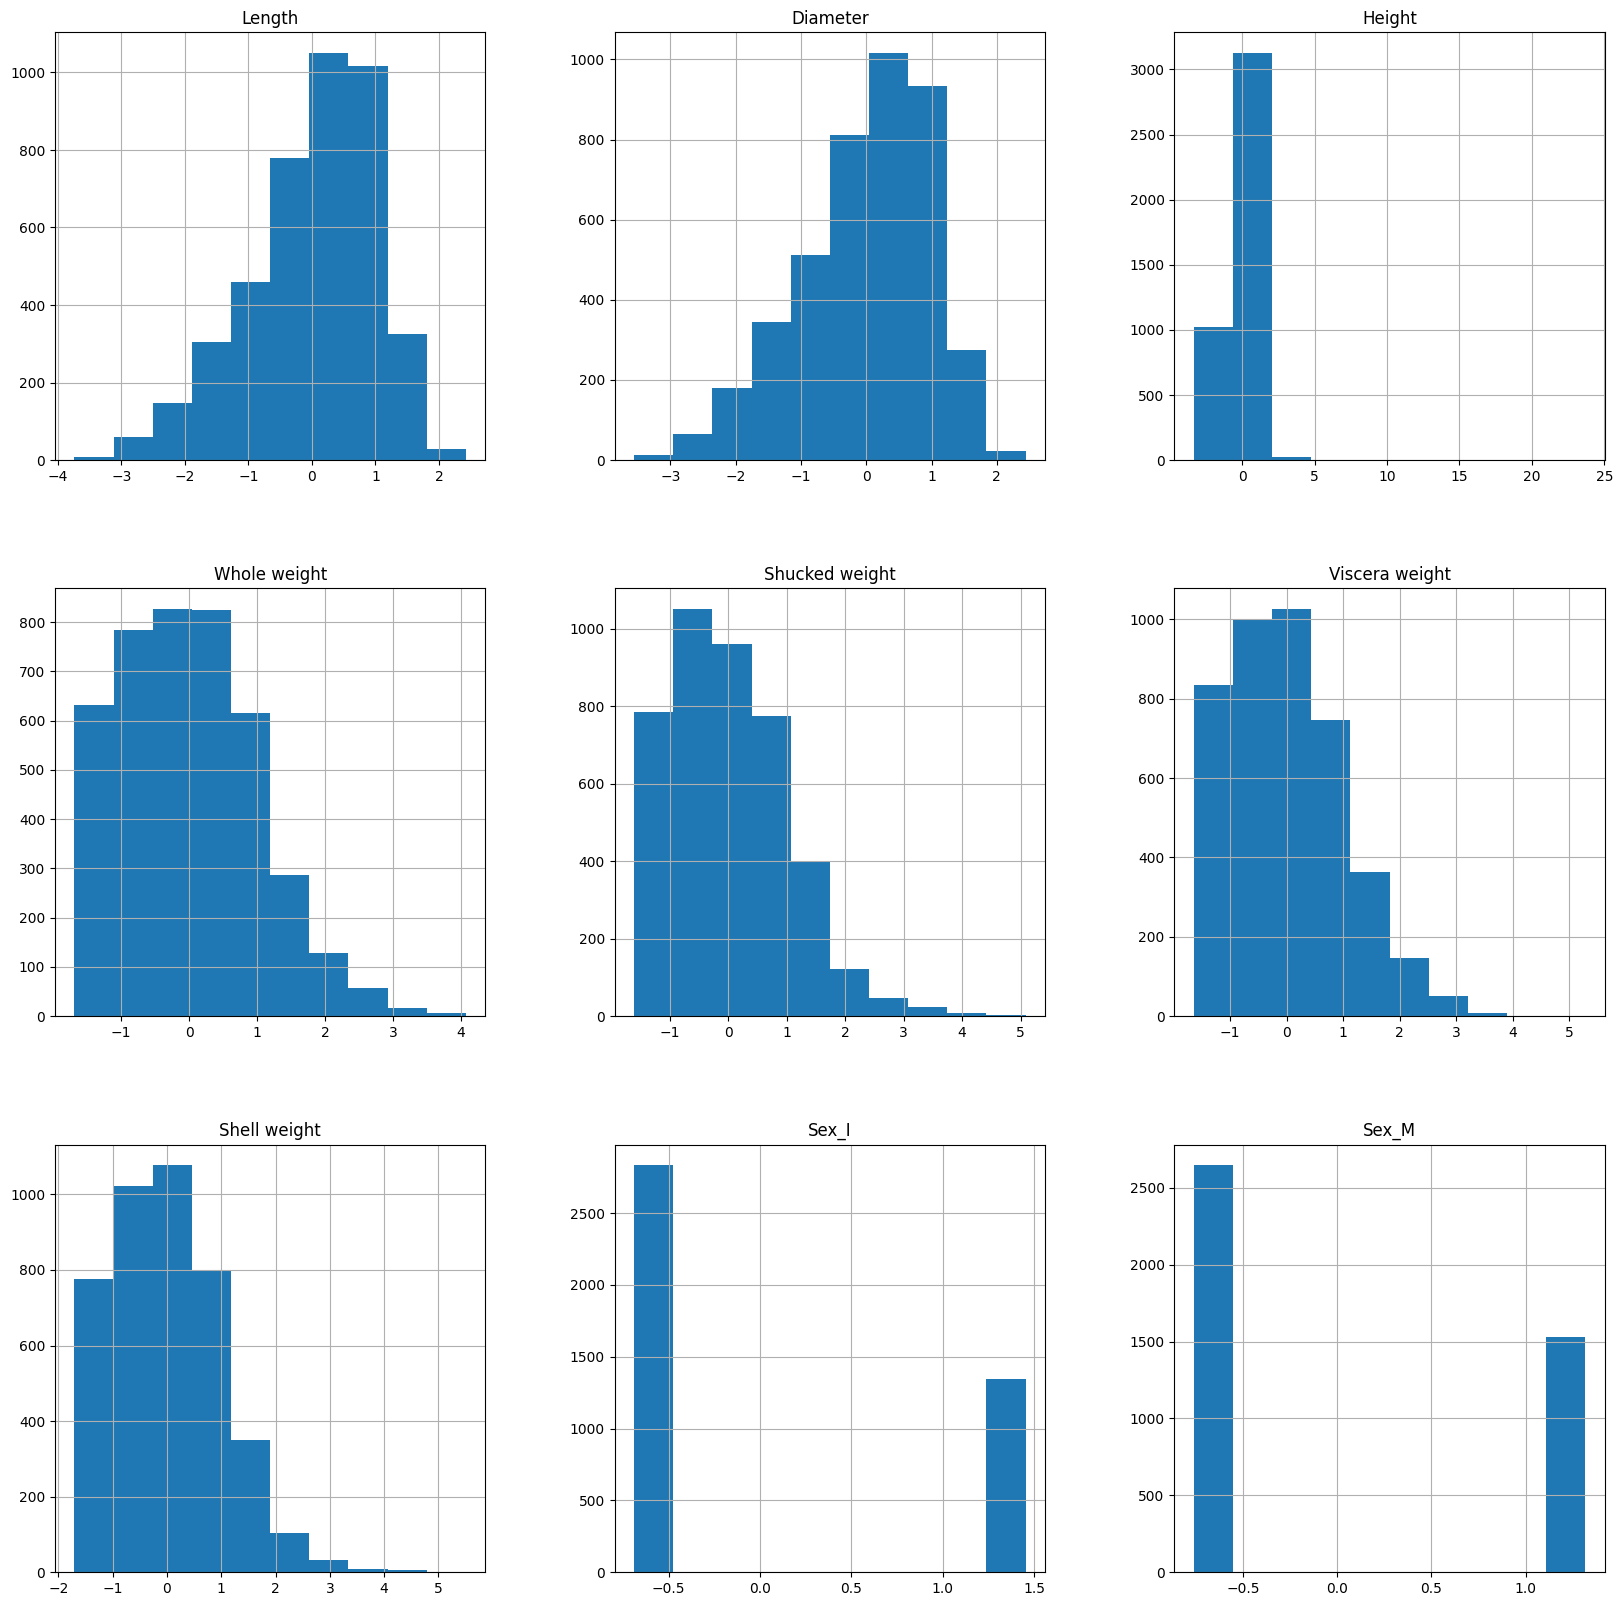

In [72]:
standardiced_features.hist(figsize=(20,20))

Jeg standardiserer treningsdataen for å kunne lage en PCA-analyse som gir en indikator på hvor mange komponenter som bør benyttes. Til trening og testing av modeller så vil den ustandardiserte dataen bli standardisert i hver fold slik at det ikke blir datalekkasje.

### PCA-analyse

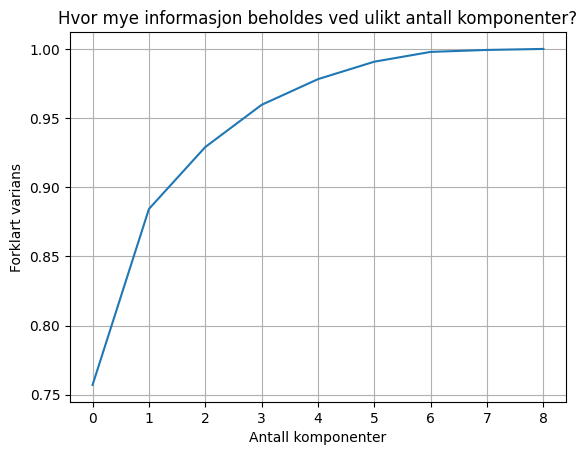

In [73]:
pca = PCA()
pca.fit(standardiced_features)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Antall komponenter')
plt.ylabel('Forklart varians')
plt.title('Hvor mye informasjon beholdes ved ulikt antall komponenter?')
plt.grid(True)
plt.show()

PCA-analyse viser at omtrent all informasjon vil bli beholdt ved 7 og 8 komponenter, men også relativt mye ved 5 og 6. Jeg ønsker derfor å teste disse.

### Funksjon for bygging av tensorflow modell

In [173]:
n_features = dataset_features.shape[1]

def build_tensorflow_model(hidden_neurons1=64, hidden_neurons2=32, dropout_rate=0.0, n_features=n_features):
    model = Sequential()
    model.add(tf.keras.Input(shape=(n_features,)))
    model.add(Dense(hidden_neurons1, activation="relu"))
    model.add(Dense(hidden_neurons2, activation="relu"))

    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation="linear"))

    model.compile(optimizer="adam", loss="mse", metrics=["mse", "mae"])

    return model

Jeg laget en funksjon som skal bygge et nevralt nettverk med tensorflow som vil bli brukt i KerasRegressor. Funksjonen tar imot antall nevroner i første og andre skjulte lag, og en dropout_rate. Modellen vil optimalisere MSE, men vil også vise MAE under trening og evaluering.

In [174]:
features_to_log = [
    "Height", 
    "Whole weight", 
    "Shucked weight", 
    "Viscera weight", 
    "Shell weight"
    ]

log_transformer = ColumnTransformer(
    transformers=[
        ('log', FunctionTransformer(np.log1p, feature_names_out='one-to-one'), features_to_log),
    ],
    remainder='passthrough'
)

### Metrikker som skal måles

In [76]:
scoring = {
    "MAE": get_scorer("neg_mean_absolute_error"),
    "MSE": get_scorer("neg_mean_squared_error"),
    "RMSE": get_scorer("neg_root_mean_squared_error"),
    "R2": get_scorer("r2")
}

Bruker den negative versjonen av metrikkene slik at ikke sklearn skal tolke høyere verdi som bedre.

### Pipelines for ulike modeller

In [182]:
global_random_state = 13
cv = KFold(n_splits=5, shuffle=True, random_state=global_random_state)

pipelines = {
    'lr_no_processing': Pipeline([
        ('lr', LinearRegression())
    ]),
    'lr_log': Pipeline([
        ('log', log_transformer),
        ('lr', LinearRegression())
    ]),
    'lr_scaled': Pipeline([
        ('scaler', scaler),
        ('lr', LinearRegression())
    ]),
    'lr_log_scaled': Pipeline([
        ('log', log_transformer),
        ('scaler', scaler),
        ('lr', LinearRegression())
    ]),
    'lr_pca8': Pipeline([
        ('scaler', scaler),
        ('pca', PCA(n_components=8)),
        ('lr', LinearRegression())
    ]),
    'lr_pca7': Pipeline([
        ('scaler', scaler),
        ('pca', PCA(n_components=7)),
        ('lr', LinearRegression())
    ]),
    'lr_pca6': Pipeline([
        ('scaler', scaler),
        ('pca', PCA(n_components=6)),
        ('lr', LinearRegression())
    ]),
    'lr_pca5': Pipeline([
        ('scaler', scaler),
        ('pca', PCA(n_components=5)),
        ('lr', LinearRegression())
    ]),

    'ri_no_processing': Pipeline([
        ('ri', Ridge())
    ]),
    'ri_log': Pipeline([
        ('log', log_transformer),
        ('ri', Ridge())
    ]),
    'ri_scaled': Pipeline([
        ('scaler', scaler),
        ('ri', Ridge())
    ]),
    'ri_log_scaled': Pipeline([
        ('log', log_transformer),
        ('scaler', scaler),
        ('ri', Ridge())
    ]),
    'ri_pca8': Pipeline([
        ('scaler', scaler),
        ('pca', PCA(n_components=8)),
        ('ri', Ridge())
    ]),
    'ri_pca7': Pipeline([
        ('scaler', scaler),
        ('pca', PCA(n_components=7)),
        ('ri', Ridge())
    ]),
    'ri_pca6': Pipeline([
        ('scaler', scaler),
        ('pca', PCA(n_components=6)),
        ('ri', Ridge())
    ]),
    'ri_pca5': Pipeline([
        ('scaler', scaler),
        ('pca', PCA(n_components=5)),
        ('ri', Ridge())
    ]),

    'rf_no_processing': Pipeline([
        ('rf', RandomForestRegressor(random_state=global_random_state))
    ]),
    'rf_log': Pipeline([
        ('log', log_transformer),
        ('rf', RandomForestRegressor(random_state=global_random_state))
    ]),
    'rf_scaled': Pipeline([
        ('scaler', scaler),
        ('rf', RandomForestRegressor(random_state=global_random_state))
    ]),
    'rf_log_scaled': Pipeline([
        ('log', log_transformer),
        ('scaler', scaler),
        ('rf', RandomForestRegressor(random_state=global_random_state))
    ]),
    'rf_pca8': Pipeline([
        ('scaler', scaler),
        ('pca', PCA(n_components=8)),
        ('rf', RandomForestRegressor(random_state=global_random_state))
    ]),
    'rf_pca7': Pipeline([
        ('scaler', scaler),
        ('pca', PCA(n_components=7)),
        ('rf', RandomForestRegressor(random_state=global_random_state))
    ]),
    'rf_pca6': Pipeline([
        ('scaler', scaler),
        ('pca', PCA(n_components=6)),
        ('rf', RandomForestRegressor(random_state=global_random_state))
    ]),
    'rf_pca5': Pipeline([
        ('scaler', scaler),
        ('pca', PCA(n_components=5)),
        ('rf', RandomForestRegressor(random_state=global_random_state))
    ]),

    'gb_no_processing': Pipeline([
        ('gb', GradientBoostingRegressor(random_state=global_random_state))
    ]),
    'gb_log': Pipeline([
        ('log', log_transformer),
        ('gb', GradientBoostingRegressor(random_state=global_random_state))
    ]),
    'gb_scaled': Pipeline([
        ('scaler', scaler),
        ('gb', GradientBoostingRegressor(random_state=global_random_state))
    ]),
    'gb_log_scaled': Pipeline([
        ('log', log_transformer),
        ('scaler', scaler),
        ('gb', GradientBoostingRegressor(random_state=global_random_state))
    ]),
    'gb_pca8': Pipeline([
        ('scaler', scaler),
        ('pca', PCA(n_components=8)),
        ('gb', GradientBoostingRegressor(random_state=global_random_state))
    ]),
    'gb_pca7': Pipeline([
        ('scaler', scaler),
        ('pca', PCA(n_components=7)),
        ('gb', GradientBoostingRegressor(random_state=global_random_state))
    ]),
    'gb_pca6': Pipeline([
        ('scaler', scaler),
        ('pca', PCA(n_components=6)),
        ('gb', GradientBoostingRegressor(random_state=global_random_state))
    ]),
    'gb_pca5': Pipeline([
        ('scaler', scaler),
        ('pca', PCA(n_components=5)),
        ('gb', GradientBoostingRegressor(random_state=global_random_state))
    ]),

    'mlp_no_processing': Pipeline([
        ('mlp', MLPRegressor(max_iter=1000, random_state=global_random_state))
    ]),
    'mlp_log': Pipeline([
        ('log', log_transformer),
        ('mlp', MLPRegressor(max_iter=1000, random_state=global_random_state))
    ]),
    'mlp_scaled': Pipeline([
        ('scaler', scaler),
        ('mlp', MLPRegressor(max_iter=1000, random_state=global_random_state))
    ]),
    'mlp_log_scaled': Pipeline([
        ('log', log_transformer),
        ('scaler', scaler),
        ('mlp', MLPRegressor(max_iter=1000, random_state=global_random_state))
    ]),
    'mlp_pca_8': Pipeline([
        ('scaler', scaler),
        ('pca', PCA(n_components=8)),
        ('mlp', MLPRegressor(max_iter=1000, random_state=global_random_state))
    ]),
    'mlp_pca_7': Pipeline([
        ('scaler', scaler),
        ('pca', PCA(n_components=7)),
        ('mlp', MLPRegressor(max_iter=1000, random_state=global_random_state))
    ]),
    'mlp_pca_6': Pipeline([
        ('scaler', scaler),
        ('pca', PCA(n_components=6)),
        ('mlp', MLPRegressor(max_iter=1000, random_state=global_random_state))
    ]),
    'mlp_pca_5': Pipeline([
        ('scaler', scaler),
        ('pca', PCA(n_components=5)),
        ('mlp', MLPRegressor(max_iter=1000, random_state=global_random_state))
    ]),

    'tf_no_processing': Pipeline([
        ('tf', KerasRegressor(model=build_tensorflow_model, epochs=15, batch_size=32, verbose=0, random_state=global_random_state))
    ]),
    'tf_log': Pipeline([
        ('log', log_transformer),
        ('tf', KerasRegressor(model=build_tensorflow_model, epochs=15, batch_size=32, verbose=0, random_state=global_random_state))
    ]),
    'tf_scaled': Pipeline([
        ('scaler', scaler),
        ('tf', KerasRegressor(model=build_tensorflow_model, epochs=15, batch_size=32, verbose=0, random_state=global_random_state))
    ]),
    'tf_log_scaled': Pipeline([
        ('log', log_transformer),
        ('scaler', scaler),
        ('tf', KerasRegressor(model=build_tensorflow_model, epochs=15, batch_size=32, verbose=0, random_state=global_random_state))
    ]),
    'tf_pca_8': Pipeline([
        ('scaler', scaler),
        ('pca', PCA(n_components=8)),
        ('tf', KerasRegressor(model=build_tensorflow_model, epochs=15, batch_size=32, verbose=0, n_features=8, random_state=global_random_state))
    ]),
    'tf_pca_7': Pipeline([
        ('scaler', scaler),
        ('pca', PCA(n_components=7)),
        ('tf', KerasRegressor(model=build_tensorflow_model, epochs=15, batch_size=32, verbose=0, n_features=7, random_state=global_random_state))
    ]),
    'tf_pca_6': Pipeline([
        ('scaler', scaler),
        ('pca', PCA(n_components=6)),
        ('tf', KerasRegressor(model=build_tensorflow_model, epochs=15, batch_size=32, verbose=0, n_features=6, random_state=global_random_state))
    ]),
    'tf_pca_5': Pipeline([
        ('scaler', scaler),
        ('pca', PCA(n_components=5)),
        ('tf', KerasRegressor(model=build_tensorflow_model, epochs=15, batch_size=32, verbose=0, n_features=5, random_state=global_random_state))
    ]),
}

Jeg lagde pipelines som preprossesserer dataen i hver fold, slik at det ikke blir noen lekasje. Jeg valgte å gjøre likt på alle, selvom standardisering ikke skal påvirke de ikke-lineære modellene. Her kan jeg få gjort AB-tester for uten preprossessering, med PCA med ulike komponenter, skalering av data, og log-transformasjon på skjeve features.

Jeg valgte modellen Linear Regression for å ha en enkel model som en baseline for sammenligning med de andre modellen. Den har ikke fått random state ettersom den er deterministisk.

Ridge Regressor valgte jeg ettersom dette er en mer stabil modell enn Linear Regression, siden den blant annet hindrer at koeffisientene blir alt for store. Ridge har ikke fått random state ettersom den er deterministisk.

Random Forest Regressor er en ikke-lineær regresjonsmodell som vil kunne håndtere ikke-lineære sammenhenger bedre enn de lineære modellene. Den bygger mange tær parallellt. Denne har fått random_state for å kunne reprodusere resultater.

Gradient Boosting Regressor er også ikke-lineær, men bygger mange mindre trær sekvensielt som lærer av hverandre. Det er en mer avansert modell enn de andre, men vil ofte gi best resultater, så jeg ønsker derfor å ta med denne.Denne har fått random_state for å kunne reprodusere resultater.

MLPRegressor er en ikke lineær nevralt nettverk-basert regresjonsmodell som kan modellere komplekse sammenhenger ved hjelp av flere skjulte lag med nevroner. Jeg valgte å sette max_iter til 1000 ettersom jeg fikk meldinger om at modellene stoppet tidligere ved lavere verdi. Denne bestemmer antall iterasjoner med oppdatering av vektene som modellene maks kan gjøre. En høyere verdi vil altså gjøre at modellene får mer tid til å tilpasse vektene, og øker sannsynligheten for gode resultater. Denne har også fått random_state for å kunne reprodusere resultater.

KerasRegressor er også en ikke lineær nevralt nettverk-basert regresjonsmodell som bruker en TensorFlow-modell for å finne komplekse sammenhenger. I denne kan man definere arkitekturen noe mer detaljert enn i MLPRegressor. Jeg satt antall epochs til 15 for å kunne få gode resultater uten alt for lang kjøretid i ab-testene. Batch_size satt jeg til 32 ettersom det er en ganske standard startverdi. Verbose satt jeg til 0 for å slippe utskrift av alt for mye unødvendig informasjon. Denne har også fått random_state for å kunne reprodusere resultater.

### AB-tester for Linear Regression

In [79]:
print("Linear Regression")
for name, pipe in pipelines.items():
    if not name.startswith(("lr")):
        continue
    cv_results = cross_validate(pipe, dataset_features, dataset_targets, cv=cv, scoring=scoring)
    print(name, ":")
    print(f"Mean Absolute Error:     {-cv_results["test_MAE"]} Gjennomsnitt: {np.mean(-cv_results["test_MAE"]):.3f}")
    print(f"Mean Squared Error:      {-cv_results["test_MSE"]} Gjennomsnitt: {np.mean(-cv_results["test_MSE"]):.3f}")
    print(f"Root Mean Squared Error: {-cv_results["test_RMSE"]} Gjennomsnitt: {np.mean(-cv_results["test_RMSE"]):.3f}")
    print(f"R2:                      {cv_results["test_R2"]} Gjennomsnitt: {np.mean(cv_results["test_R2"]):.3f}")

Linear Regression
lr_no_processing :
Mean Absolute Error:     [1.55462848 1.53793764 1.62407926 1.57423857 1.64459579] Gjennomsnitt: 1.587
Mean Squared Error:      [4.55690103 4.45543882 5.47801315 4.91852009 5.29641864] Gjennomsnitt: 4.941
Root Mean Squared Error: [2.13468991 2.11079104 2.34051557 2.21777368 2.30139493] Gjennomsnitt: 2.221
R2:                      [0.55014479 0.56228112 0.49098454 0.5335113  0.48699873] Gjennomsnitt: 0.525
lr_log :
Mean Absolute Error:     [1.50162954 1.5211569  1.57150893 1.54924904 1.61195006] Gjennomsnitt: 1.551
Mean Squared Error:      [4.38083894 4.36196795 4.82371613 4.68800426 5.03840676] Gjennomsnitt: 4.659
Root Mean Squared Error: [2.09304537 2.08853249 2.196296   2.16517996 2.24463956] Gjennomsnitt: 2.158
R2:                      [0.56752556 0.57146404 0.55178163 0.55537418 0.51198929] Gjennomsnitt: 0.552
lr_scaled :
Mean Absolute Error:     [1.55462848 1.53793764 1.62407926 1.57423857 1.64459579] Gjennomsnitt: 1.587
Mean Squared Error:     

Ved å gjøre en ABCD-test for Linear Regression så viser det seg at modellen fungerer best uten PCA, på log-transformert data. Om dataen er standardisert påvirker ingenting. Den har lavest på alle error verdier, og høyest R2-score.

### AB-tester for Ridge Regressor

In [80]:
print("Ridge")
for name, pipe in pipelines.items():
    if not name.startswith(("ri")):
        continue
    cv_results = cross_validate(pipe, dataset_features, dataset_targets, cv=cv, scoring=scoring)
    print(name, ":")
    print(f"Mean Absolute Error:     {-cv_results["test_MAE"]} Gjennomsnitt: {np.mean(-cv_results["test_MAE"]):.3f}")
    print(f"Mean Squared Error:      {-cv_results["test_MSE"]} Gjennomsnitt: {np.mean(-cv_results["test_MSE"]):.3f}")
    print(f"Root Mean Squared Error: {-cv_results["test_RMSE"]} Gjennomsnitt: {np.mean(-cv_results["test_RMSE"]):.3f}")
    print(f"R2:                      {cv_results["test_R2"]} Gjennomsnitt: {np.mean(cv_results["test_R2"]):.3f}")

Ridge
ri_no_processing :
Mean Absolute Error:     [1.5575783  1.54565123 1.61307015 1.58581593 1.6375987 ] Gjennomsnitt: 1.588
Mean Squared Error:      [4.56736131 4.50330389 5.09860218 4.99564197 5.23108879] Gjennomsnitt: 4.879
Root Mean Squared Error: [2.13713858 2.12209894 2.25800845 2.23509328 2.28715736] Gjennomsnitt: 2.208
R2:                      [0.54911215 0.55757867 0.5262393  0.52619681 0.49332646] Gjennomsnitt: 0.530
ri_log :
Mean Absolute Error:     [1.5222525  1.534913   1.57179251 1.57235451 1.60689574] Gjennomsnitt: 1.562
Mean Squared Error:      [4.42369726 4.44906001 4.80374791 4.87757032 5.0209819 ] Gjennomsnitt: 4.715
Root Mean Squared Error: [2.10325872 2.1092795  2.1917454  2.2085222  2.24075476] Gjennomsnitt: 2.171
R2:                      [0.5632946  0.56290779 0.55363707 0.53739511 0.51367703] Gjennomsnitt: 0.546
ri_scaled :
Mean Absolute Error:     [1.55452604 1.53804802 1.62437081 1.57459408 1.64339483] Gjennomsnitt: 1.587
Mean Squared Error:      [4.55334104

Ridge gir best resultater på log-transformert og standardisert data. Metrikkene er helt like som på LinearRegression, men på ustandardisert data så er faktisk Ridge noe dårligere. Dette er fordi Ridge gir l2-regularisering som straffer store koeffisienter. I motsetning til Linear Regression så bør Ridge tunes, så den vil trolig gi noe bedre metrikker ved hyperparametertuning senere.

### AB-tester for Random Forest Regressor

In [81]:
print("Random Forest Regressor")
for name, pipe in pipelines.items():
    if not name.startswith(("rf")):
        continue
    cv_results = cross_validate(pipe, dataset_features, dataset_targets, cv=cv, scoring=scoring)
    print(name, ":")
    print(f"Mean Absolute Error:     {-cv_results["test_MAE"]} Gjennomsnitt: {np.mean(-cv_results["test_MAE"]):.3f}")
    print(f"Mean Squared Error:      {-cv_results["test_MSE"]} Gjennomsnitt: {np.mean(-cv_results["test_MSE"]):.3f}")
    print(f"Root Mean Squared Error: {-cv_results["test_RMSE"]} Gjennomsnitt: {np.mean(-cv_results["test_RMSE"]):.3f}")
    print(f"R2:                      {cv_results["test_R2"]} Gjennomsnitt: {np.mean(cv_results["test_R2"]):.3f}")

Random Forest Regressor
rf_no_processing :
Mean Absolute Error:     [1.49397129 1.52308612 1.57449102 1.53577246 1.60396407] Gjennomsnitt: 1.546
Mean Squared Error:      [4.52736699 4.66658732 5.06819856 4.7013297  4.87189856] Gjennomsnitt: 4.767
Root Mean Squared Error: [2.12776103 2.16022853 2.25126599 2.16825499 2.20723777] Gjennomsnitt: 2.183
R2:                      [0.55306038 0.5415371  0.52906439 0.55411035 0.52811696] Gjennomsnitt: 0.541
rf_log :
Mean Absolute Error:     [1.49220096 1.51894737 1.57702994 1.53471856 1.60526946] Gjennomsnitt: 1.546
Mean Squared Error:      [4.51997847 4.6610622  5.08025437 4.69204275 4.8460994 ] Gjennomsnitt: 4.760
Root Mean Squared Error: [2.1260241  2.15894933 2.25394196 2.16611236 2.20138579] Gjennomsnitt: 2.181
R2:                      [0.55378977 0.54207991 0.52794417 0.55499116 0.53061582] Gjennomsnitt: 0.542
rf_scaled :
Mean Absolute Error:     [1.49259569 1.52339713 1.57590419 1.53876647 1.60342515] Gjennomsnitt: 1.547
Mean Squared Error

Random Forest Regressor gir litt dårligere metrikker enn Linear Regression og Ridge uten tuning. Skalering påvirker omtrent ingenting, mens log gjør en minimal forbedring. Modellene blir dårligere jo færre komponenter som blir brukt. Det beste er altså å bruke uten PCA, ustandardisert, med log.

### AB-tester for Gradient Boosting Regressor

In [82]:
print("Gradient Boosting Regressor")
for name, pipe in pipelines.items():
    if not name.startswith(("gb")):
        continue
    cv_results = cross_validate(pipe, dataset_features, dataset_targets, cv=cv, scoring=scoring)
    print(name, ":")
    print(f"Mean Absolute Error:     {-cv_results["test_MAE"]} Gjennomsnitt: {np.mean(-cv_results["test_MAE"]):.3f}")
    print(f"Mean Squared Error:      {-cv_results["test_MSE"]} Gjennomsnitt: {np.mean(-cv_results["test_MSE"]):.3f}")
    print(f"Root Mean Squared Error: {-cv_results["test_RMSE"]} Gjennomsnitt: {np.mean(-cv_results["test_RMSE"]):.3f}")
    print(f"R2:                      {cv_results["test_R2"]} Gjennomsnitt: {np.mean(cv_results["test_R2"]):.3f}")

Gradient Boosting Regressor
gb_no_processing :
Mean Absolute Error:     [1.48374998 1.4864812  1.55907532 1.52017234 1.56778553] Gjennomsnitt: 1.523
Mean Squared Error:      [4.52176599 4.4558317  4.9748795  4.64652029 4.82344066] Gjennomsnitt: 4.684
Root Mean Squared Error: [2.12644445 2.1108841  2.23044379 2.15557888 2.19623329] Gjennomsnitt: 2.164
R2:                      [0.5536133  0.56224252 0.53773558 0.55930866 0.5328105 ] Gjennomsnitt: 0.549
gb_log :
Mean Absolute Error:     [1.48468604 1.48621    1.5586294  1.51960515 1.56980861] Gjennomsnitt: 1.524
Mean Squared Error:      [4.53159654 4.45206347 4.97451509 4.64000477 4.8190497 ] Gjennomsnitt: 4.683
Root Mean Squared Error: [2.12875469 2.10999134 2.2303621  2.15406703 2.19523341] Gjennomsnitt: 2.164
R2:                      [0.55264284 0.56261272 0.53776944 0.55992661 0.5332358 ] Gjennomsnitt: 0.549
gb_scaled :
Mean Absolute Error:     [1.48398114 1.48574985 1.55889523 1.52137306 1.56818575] Gjennomsnitt: 1.524
Mean Squared E

Gradient Boosting Regressor ga bedre metrikker enn Random Forest, men noe lavere enn Ridge og Linear Regression. Dette er trolig fordi denne trenger mer tuning. Her er det best uten PCA, mens log og skalering ser ut til å påvirke modellen omtrent ingenting.

### AB-tester for MLP Regressor

In [183]:
print("MLP Regressor")
for name, pipe in pipelines.items():
    if not name.startswith(("mlp")):
        continue
    cv_results = cross_validate(pipe, dataset_features, dataset_targets, cv=cv, scoring=scoring)
    print(name, ":")
    print(f"Mean Absolute Error:     {-cv_results["test_MAE"]} Gjennomsnitt: {np.mean(-cv_results["test_MAE"]):.3f}")
    print(f"Mean Squared Error:      {-cv_results["test_MSE"]} Gjennomsnitt: {np.mean(-cv_results["test_MSE"]):.3f}")
    print(f"Root Mean Squared Error: {-cv_results["test_RMSE"]} Gjennomsnitt: {np.mean(-cv_results["test_RMSE"]):.3f}")
    print(f"R2:                      {cv_results["test_R2"]} Gjennomsnitt: {np.mean(cv_results["test_R2"]):.3f}")

MLP Regressor
mlp_no_processing :
Mean Absolute Error:     [1.46411184 1.47332823 1.56118807 1.51391986 1.56544163] Gjennomsnitt: 1.516
Mean Squared Error:      [4.20538379 4.36387073 4.99589808 4.56001485 4.9566399 ] Gjennomsnitt: 4.616
Root Mean Squared Error: [2.05070324 2.08898797 2.23515057 2.13541913 2.22635125] Gjennomsnitt: 2.147
R2:                      [0.58484641 0.57127711 0.53578253 0.56751312 0.51990907] Gjennomsnitt: 0.556
mlp_log :
Mean Absolute Error:     [1.44948026 1.49154691 1.53613304 1.51121898 1.57675059] Gjennomsnitt: 1.513
Mean Squared Error:      [4.21032945 4.33836676 4.73653771 4.5302972  4.87170482] Gjennomsnitt: 4.537
Root Mean Squared Error: [2.05190873 2.08287464 2.17635882 2.12844948 2.20719388] Gjennomsnitt: 2.129
R2:                      [0.58435818 0.57378271 0.55988223 0.57033164 0.52813573] Gjennomsnitt: 0.563
mlp_scaled :
Mean Absolute Error:     [1.46882136 1.44603179 1.51615617 1.4456449  1.54287042] Gjennomsnitt: 1.484
Mean Squared Error:      

/Users/finken/Documents/Skole/Praktisk maskinlæring/Oblig 4/Mandatory_Artificial_Neural_Networks/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


mlp_pca_5 :
Mean Absolute Error:     [1.65759477 1.61105343 1.67540767 1.68919805 1.71129865] Gjennomsnitt: 1.669
Mean Squared Error:      [5.59525461 5.15782913 5.84603876 5.6709414  5.80219967] Gjennomsnitt: 5.614
Root Mean Squared Error: [2.36542905 2.27108545 2.4178583  2.38137385 2.40877556] Gjennomsnitt: 2.369
R2:                      [0.44763899 0.49327568 0.4567877  0.46214918 0.43800972] Gjennomsnitt: 0.460


MLP Regressor ga klart best metrikker til nå. Denne fungerer best på log-transformert og standardisert data.

### AB-tester for Keras Regressor 

In [185]:
print("Keras Regressor (Tensorflow)")
for name, pipe in pipelines.items():
    if not name.startswith(("tf")):
        continue
    cv_results = cross_validate(pipe, dataset_features, dataset_targets, cv=cv, scoring=scoring)
    print(name, ":")
    print(f"Mean Absolute Error:     {-cv_results["test_MAE"]} Gjennomsnitt: {np.mean(-cv_results["test_MAE"]):.3f}")
    print(f"Mean Squared Error:      {-cv_results["test_MSE"]} Gjennomsnitt: {np.mean(-cv_results["test_MSE"]):.3f}")
    print(f"Root Mean Squared Error: {-cv_results["test_RMSE"]} Gjennomsnitt: {np.mean(-cv_results["test_RMSE"]):.3f}")
    print(f"R2:                      {cv_results["test_R2"]} Gjennomsnitt: {np.mean(cv_results["test_R2"]):.3f}")

Keras Regressor (Tensorflow)


2025-12-02 17:51:01.845966: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-12-02 17:51:07.858696: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

tf_no_processing :
Mean Absolute Error:     [1.60969758 1.55561173 1.61760724 1.78317559 1.78070986] Gjennomsnitt: 1.669
Mean Squared Error:      [4.56314707 4.5941596  5.03568411 5.3295064  5.40391541] Gjennomsnitt: 4.985
Root Mean Squared Error: [2.13615251 2.143399   2.2440331  2.30857229 2.32463241] Gjennomsnitt: 2.231
R2:                      [0.54952818 0.54865265 0.5320856  0.49453199 0.47658682] Gjennomsnitt: 0.520


2025-12-02 17:51:13.782261: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


tf_log :
Mean Absolute Error:     [1.65823257 1.59900463 1.61975932 1.82220769 1.81701088] Gjennomsnitt: 1.703
Mean Squared Error:      [4.78275681 4.91762114 5.1991334  5.54661894 5.63368273] Gjennomsnitt: 5.216
Root Mean Squared Error: [2.1869514  2.21757102 2.2801609  2.35512614 2.37353802] Gjennomsnitt: 2.283
R2:                      [0.52784836 0.51687455 0.51689792 0.47394031 0.45433199] Gjennomsnitt: 0.498


2025-12-02 17:51:19.341876: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


tf_scaled :
Mean Absolute Error:     [1.51614487 1.46490455 1.61420107 1.52984786 1.62276423] Gjennomsnitt: 1.550
Mean Squared Error:      [4.2995615  4.32072306 8.71932316 4.52809334 4.95605373] Gjennomsnitt: 5.365
Root Mean Squared Error: [2.0735383  2.07863498 2.9528501  2.12793159 2.22621965] Gjennomsnitt: 2.292
R2:                      [0.57554924 0.5755161  0.18980289 0.57054067 0.51996589] Gjennomsnitt: 0.486


2025-12-02 17:51:24.670356: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


tf_log_scaled :
Mean Absolute Error:     [1.49928665 1.47349238 1.59117854 1.52627563 1.60069704] Gjennomsnitt: 1.538
Mean Squared Error:      [4.22318649 4.36740637 6.7903986  4.48836184 4.825984  ] Gjennomsnitt: 4.939
Root Mean Squared Error: [2.05503941 2.08983397 2.60583925 2.11857533 2.19681215] Gjennomsnitt: 2.213
R2:                      [0.58308887 0.57092971 0.36903799 0.57430887 0.53256416] Gjennomsnitt: 0.526


2025-12-02 17:51:30.374211: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


tf_pca_8 :
Mean Absolute Error:     [1.52849352 1.50806272 1.62202787 1.55689728 1.64351869] Gjennomsnitt: 1.572
Mean Squared Error:      [4.42802954 4.52025795 8.01132107 4.68222046 5.06373453] Gjennomsnitt: 5.341
Root Mean Squared Error: [2.10428834 2.12608981 2.83042765 2.16384387 2.25027442] Gjennomsnitt: 2.295
R2:                      [0.56286693 0.55591297 0.2555902  0.55592275 0.50953615] Gjennomsnitt: 0.488


2025-12-02 17:51:36.369915: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


tf_pca_7 :
Mean Absolute Error:     [1.52899158 1.51019371 1.62166703 1.55791891 1.63292527] Gjennomsnitt: 1.570
Mean Squared Error:      [4.44444847 4.54115057 8.06388283 4.6827774  5.03015232] Gjennomsnitt: 5.352
Root Mean Squared Error: [2.10818601 2.13099766 2.8396976  2.16397262 2.2428    ] Gjennomsnitt: 2.297
R2:                      [0.56124604 0.55386043 0.25070626 0.55586994 0.51278877] Gjennomsnitt: 0.487


2025-12-02 17:51:41.942393: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


tf_pca_6 :
Mean Absolute Error:     [1.5569005  1.52949512 1.6142261  1.56394887 1.65746808] Gjennomsnitt: 1.584
Mean Squared Error:      [4.50888443 4.57787609 8.32337761 4.70818329 5.14635468] Gjennomsnitt: 5.453
Root Mean Squared Error: [2.12341332 2.13959718 2.88502645 2.16983485 2.26855779] Gjennomsnitt: 2.317
R2:                      [0.55488491 0.55025238 0.22659397 0.55346036 0.50153369] Gjennomsnitt: 0.477
tf_pca_5 :
Mean Absolute Error:     [1.7996701  1.74136662 1.77123225 1.81454635 1.82946968] Gjennomsnitt: 1.791
Mean Squared Error:      [ 5.89638615  5.94942331 13.95905495  6.3339715   6.45970154] Gjennomsnitt: 7.720
Root Mean Squared Error: [2.42824745 2.4391439  3.73618197 2.51673818 2.54159427] Gjennomsnitt: 2.732
R2:                      [ 0.41791135  0.41550648 -0.29707158  0.39926523  0.37432539] Gjennomsnitt: 0.262


2025-12-02 17:51:47.468431: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


Keras Regressor gir foreløpig dårligst metrikekr av alle modeller. Denne behøver trolig mer tuning. Slik som på MLP fungerer denne også best på log-transformert og standardisert data.

### Log-transformasjon av targets

### Linear Regression

In [83]:
lr_log = pipelines['lr_log']

lr_target_log = TransformedTargetRegressor(
    regressor=lr_log,
    func=np.log1p,
    inverse_func=np.expm1
)
cv_results = cross_validate(lr_log, dataset_features, dataset_targets, cv=cv, scoring=scoring)
print("Ingen log på target:")
print(f"Mean Absolute Error:     {-cv_results["test_MAE"]} Gjennomsnitt: {np.mean(-cv_results["test_MAE"]):.3f}")
print(f"Mean Squared Error:      {-cv_results["test_MSE"]} Gjennomsnitt: {np.mean(-cv_results["test_MSE"]):.3f}")
print(f"Root Mean Squared Error: {-cv_results["test_RMSE"]} Gjennomsnitt: {np.mean(-cv_results["test_RMSE"]):.3f}")
print(f"R2:                      {cv_results["test_R2"]} Gjennomsnitt: {np.mean(cv_results["test_R2"]):.3f}")

cv_results_target_log = cross_validate(lr_target_log, dataset_features, dataset_targets, cv=cv, scoring=scoring)
print("Med log på target:")
print(f"Mean Absolute Error:     {-cv_results_target_log["test_MAE"]} Gjennomsnitt: {np.mean(-cv_results_target_log["test_MAE"]):.3f}")
print(f"Mean Squared Error:      {-cv_results_target_log["test_MSE"]} Gjennomsnitt: {np.mean(-cv_results_target_log["test_MSE"]):.3f}")
print(f"Root Mean Squared Error: {-cv_results_target_log["test_RMSE"]} Gjennomsnitt: {np.mean(-cv_results_target_log["test_RMSE"]):.3f}")
print(f"R2:                      {cv_results_target_log["test_R2"]} Gjennomsnitt: {np.mean(cv_results_target_log["test_R2"]):.3f}")

Ingen log på target:
Mean Absolute Error:     [1.50162954 1.5211569  1.57150893 1.54924904 1.61195006] Gjennomsnitt: 1.551
Mean Squared Error:      [4.38083894 4.36196795 4.82371613 4.68800426 5.03840676] Gjennomsnitt: 4.659
Root Mean Squared Error: [2.09304537 2.08853249 2.196296   2.16517996 2.24463956] Gjennomsnitt: 2.158
R2:                      [0.56752556 0.57146404 0.55178163 0.55537418 0.51198929] Gjennomsnitt: 0.552
Med log på target:
Mean Absolute Error:     [1.50328085 1.50256976 1.5786129  1.54620581 1.60504562] Gjennomsnitt: 1.547
Mean Squared Error:      [4.4870026  4.40561969 5.56902857 4.91717384 5.15507225] Gjennomsnitt: 4.907
Root Mean Squared Error: [2.11825461 2.09895681 2.35987893 2.21747014 2.27047842] Gjennomsnitt: 2.213
R2:                      [0.55704513 0.56717553 0.48252741 0.53363898 0.50068928] Gjennomsnitt: 0.528


Ved å ta log-transformasjon på targets fikk jeg litt dårligere metrikker på Linear Regression, dette er trolig fordi målvariabelen ikke er skjevt nok fordelt.

### Ridge Regression

In [130]:
ri_log_scaled = pipelines['ri_log_scaled']

ri_target_log = TransformedTargetRegressor(
    regressor=ri_log_scaled,
    func=np.log1p,
    inverse_func=np.expm1
)
cv_results = cross_validate(ri_log_scaled, dataset_features, dataset_targets, cv=cv, scoring=scoring)
print("Ingen log på target:")
print(f"Mean Absolute Error:     {-cv_results["test_MAE"]} Gjennomsnitt: {np.mean(-cv_results["test_MAE"]):.3f}")
print(f"Mean Squared Error:      {-cv_results["test_MSE"]} Gjennomsnitt: {np.mean(-cv_results["test_MSE"]):.3f}")
print(f"Root Mean Squared Error: {-cv_results["test_RMSE"]} Gjennomsnitt: {np.mean(-cv_results["test_RMSE"]):.3f}")
print(f"R2:                      {cv_results["test_R2"]} Gjennomsnitt: {np.mean(cv_results["test_R2"]):.3f}")

cv_results_target_log = cross_validate(ri_target_log, dataset_features, dataset_targets, cv=cv, scoring=scoring)
print("Med log på target:")
print(f"Mean Absolute Error:     {-cv_results_target_log["test_MAE"]} Gjennomsnitt: {np.mean(-cv_results_target_log["test_MAE"]):.3f}")
print(f"Mean Squared Error:      {-cv_results_target_log["test_MSE"]} Gjennomsnitt: {np.mean(-cv_results_target_log["test_MSE"]):.3f}")
print(f"Root Mean Squared Error: {-cv_results_target_log["test_RMSE"]} Gjennomsnitt: {np.mean(-cv_results_target_log["test_RMSE"]):.3f}")
print(f"R2:                      {cv_results_target_log["test_R2"]} Gjennomsnitt: {np.mean(cv_results_target_log["test_R2"]):.3f}")

Ingen log på target:
Mean Absolute Error:     [1.50303208 1.52091664 1.57188086 1.54873012 1.6106438 ] Gjennomsnitt: 1.551
Mean Squared Error:      [4.37760801 4.36009072 4.83756121 4.69166559 5.02709328] Gjennomsnitt: 4.659
Root Mean Squared Error: [2.09227341 2.08808303 2.19944566 2.1660253  2.24211804] Gjennomsnitt: 2.158
R2:                      [0.56784452 0.57164847 0.55049515 0.55502693 0.51308509] Gjennomsnitt: 0.552
Med log på target:
Mean Absolute Error:     [1.50512266 1.50362117 1.57985245 1.54621803 1.60473184] Gjennomsnitt: 1.548
Mean Squared Error:      [4.49320869 4.41051216 5.60972786 4.92128772 5.15900654] Gjennomsnitt: 4.919
Root Mean Squared Error: [2.11971901 2.10012194 2.36848641 2.21839756 2.27134466] Gjennomsnitt: 2.216
R2:                      [0.55643247 0.56669488 0.47874564 0.53324881 0.50030822] Gjennomsnitt: 0.527


Jeg fikk omtrent samme resultater med log-transformasjon av target på Ridge som på Linear Regression. Denne ble også dårligere.

Siden det gir klart dårligere metrikker på disse, spesielt på MSE, så lar jeg vær å teste for de andre modellene.

## Hyperparameter-tuning

### Funksjoner for Trening og Evaluering

In [85]:
def evaluate(estimator, X, y):
    scores = {}
    for (name,scorer) in scoring.items():
        scores[name] = scorer(estimator, X, y) 
    return scores

In [86]:
def train(estimator, params, features, targets, scoring=scoring, refit='MAE', random_state=global_random_state):
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=global_random_state)
    inner_cv = KFold(n_splits=4, shuffle=True, random_state=global_random_state)

    scores = []
    estimators = []
    cv_results = []

    for (train_index, test_index) in outer_cv.split(features, targets):

        grid = GridSearchCV(
            estimator,
            params, 
            scoring=scoring, 
            refit=refit,
            error_score='raise',
            cv=inner_cv,
            n_jobs=-2)
        grid.fit(features.iloc[train_index], targets.iloc[train_index])
        evaluation = evaluate(grid, features.iloc[test_index], targets.iloc[test_index])
        scores.append(evaluation)
        estimators.append(grid.best_estimator_)
        cv_results.append(pd.DataFrame(grid.cv_results_))

    return estimators, pd.DataFrame(scores), pd.concat(cv_results, names=['test_split'], keys=range(5))

Jeg bruker nested cross-validation for å finne de beste hyperparameterene for hver modell, uten datalekasje.

Jeg valgte å ta hyperparametertuning basert på Mean Absolute Error (MAE). Dette er fordi denne er mest robust mot uteliggere, noe som finnes i datasettet. Det er også en veldig meningsfull måling ettersom den forteller hvor mange ringer som bommes på i snitt.

### Modellene som skal tunes

In [189]:
lr_pipe = Pipeline([
        ('log', log_transformer),
        ('lr', LinearRegression())
    ])
ri_pipe = Pipeline([
        ('log', log_transformer),
        ('scale', scaler),
        ('ri', Ridge())
    ])
rf_pipe = Pipeline([
        ('log', log_transformer),
        ('rf', RandomForestRegressor(random_state=global_random_state))
    ])
gb_pipe = Pipeline([
        ('gb', GradientBoostingRegressor(random_state=global_random_state))
    ])
mlp_pipe = Pipeline([
        ('log', log_transformer),
        ('scaler', scaler),
        ('mlp', MLPRegressor(max_iter=2000, random_state=global_random_state))
])
tf_pipe = Pipeline([
        ('log', log_transformer),
        ('scaler', scaler),
        ('tf', KerasRegressor(model=build_tensorflow_model,verbose=0, random_state=global_random_state))
    ])

### Linear Regression

In [133]:
lr_params_final = {}

In [134]:
lr_estimators_final, lr_scores_final, lr_cv_results_final = train(
    lr_pipe, 
    lr_params_final,
    dataset_features,
    dataset_targets
    )
lr_scores_final = pd.DataFrame(lr_scores_final)
lr_scores_final.describe()

,MAE,MSE,RMSE,R2
count,5.000000,5.000000,5.000000,5.000000
mean,-1.551099,-4.658587,-2.157539,0.551627
std,0.043205,0.290484,0.067209,0.023619
min,-1.611950,-5.038407,-2.244640,0.511989
25%,-1.571509,-4.823716,-2.196296,0.551782
50%,-1.549249,-4.688004,-2.165180,0.555374
75%,-1.521157,-4.380839,-2.093045,0.567526
max,-1.501630,-4.361968,-2.088532,0.571464


Linear Regression behøver ikke tuning. 

### Ridge

In [135]:
ri_params = {
    'ri__alpha': [0.001, 0.1, 1.0, 10.0, 100.0]
}

For Ridge så er alpha den viktigste parameteren å tune. Denne bestemmer hvor kompleks modellen skal være ved å straffe store koeffisienter. En lav alpha-verdi vil kunne gjøre at modellen kan finne komplekse sammenhenger, men det kan samtidig føre til overfitting. En høyere alpha-verdi vil kunne gjøre modellen mer robust og stabil, og senke sjansen for overfitting, samtidig kan det føre til for dårlige prediksjoner om modellen blir for enkel. Jeg starter med å teste brede verdier.

In [136]:
ri_estimators, ri_scores, ri_cv_results = train(
    ri_pipe, 
    ri_params,
    dataset_features,
    dataset_targets
    )
ri_scores = pd.DataFrame(ri_scores)
ri_scores.describe()

,MAE,MSE,RMSE,R2
count,5.000000,5.000000,5.000000,5.000000
mean,-1.551112,-4.655633,-2.156869,0.551914
std,0.042351,0.287649,0.066599,0.023220
min,-1.610644,-5.027093,-2.242118,0.513085
25%,-1.571509,-4.823730,-2.196299,0.551780
50%,-1.549248,-4.688008,-2.165181,0.555374
75%,-1.521128,-4.377608,-2.092273,0.567845
max,-1.503032,-4.361724,-2.088474,0.571488


<Axes: xlabel='param_ri__alpha', ylabel='mean_test_MAE'>

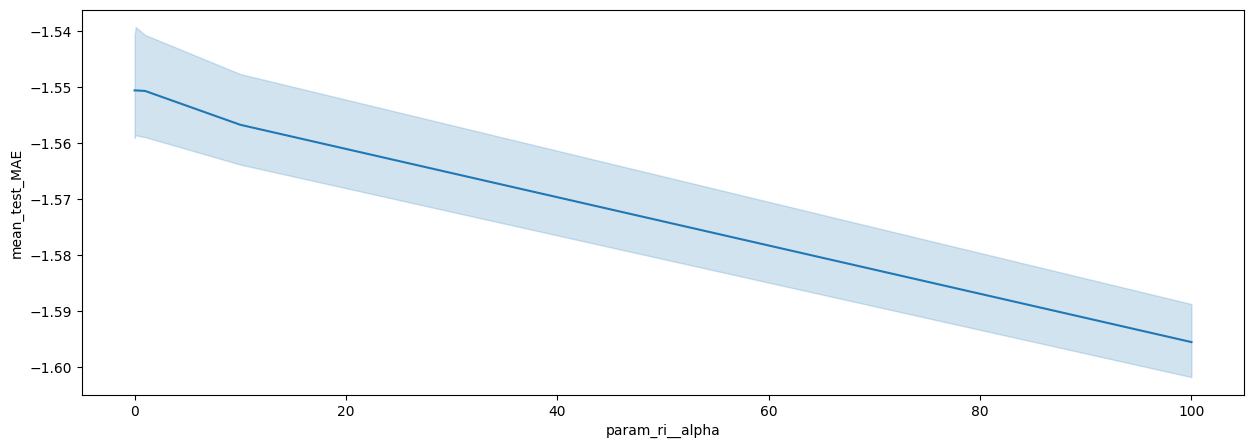

In [92]:
fig, ax = plt.subplots(1, figsize=(15, 5))
sb.lineplot(data=ri_cv_results, x='param_ri__alpha', y='mean_test_MAE', ax=ax)

Ridge fungerer best på en lavere alpha-verdi. Jeg velger derfor å teste lavere verdier nærmere.

### Ridge; forbedret parametere

In [137]:
ri_params2 = {
    'ri__alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 1.0, 10]
}

In [138]:
ri_estimators2, ri_scores2, ri_cv_results2 = train(
    ri_pipe, 
    ri_params2,
    dataset_features,
    dataset_targets
    )
ri_scores2 = pd.DataFrame(ri_scores2)
ri_scores2.describe()

,MAE,MSE,RMSE,R2
count,5.000000,5.000000,5.000000,5.000000
mean,-1.551112,-4.655633,-2.156869,0.551914
std,0.042351,0.287649,0.066599,0.023220
min,-1.610644,-5.027093,-2.242118,0.513085
25%,-1.571509,-4.823730,-2.196299,0.551780
50%,-1.549248,-4.688008,-2.165181,0.555374
75%,-1.521128,-4.377608,-2.092273,0.567845
max,-1.503032,-4.361724,-2.088474,0.571488


<Axes: xlabel='param_ri__alpha', ylabel='mean_test_MAE'>

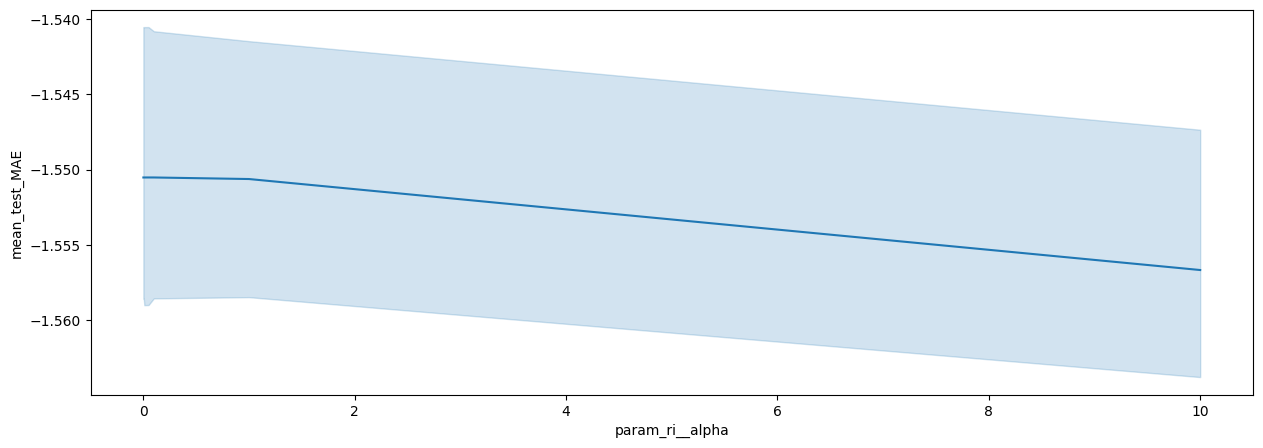

In [139]:
fig, ax = plt.subplots(1, figsize=(15, 5))
sb.lineplot(data=ri_cv_results2, x='param_ri__alpha', y='mean_test_MAE', ax=ax)

Her fikk jeg flatet ut grafen, men fikk ikke noen særlig forbedring på metrikkene. Dette betyr at videre tuning påvirker modellen svært lite. Variasjonen kommer hovedsakelig fra hvordan datasettet blir splittet. Metrikkene er også omtrent like som uten tuning.

In [140]:
columns = [
    'param_ri__alpha',
    'mean_test_MAE'
]

ri_cv_results2_sorted = (
    ri_cv_results2[columns].groupby(['param_ri__alpha'],
        as_index=False)['mean_test_MAE'].mean().sort_values('mean_test_MAE', ascending=False)
)

ri_cv_results2_sorted.head()

,param_ri__alpha,mean_test_MAE
3,0.050,-1.550528
4,0.100,-1.550528
2,0.010,-1.550528
1,0.005,-1.550528
0,0.001,-1.550529


Får relativt liten forbedring med hyperparametertuning. Fungerer i snitt best på aøpha 0.05-0.005

### Ridge; endelige parametere

In [141]:
ri_params_final = {
    'ri__alpha': [0.05]
}

In [142]:
ri_estimators_final, ri_scores_final, ri_cv_results_final = train(
    ri_pipe, 
    ri_params_final,
    dataset_features,
    dataset_targets
    )
ri_scores_final = pd.DataFrame(ri_scores_final)
ri_scores_final.describe()

,MAE,MSE,RMSE,R2
count,5.000000,5.000000,5.000000,5.000000
mean,-1.551089,-4.658567,-2.157534,0.551630
std,0.043160,0.290459,0.067206,0.023599
min,-1.611864,-5.037768,-2.244497,0.512051
25%,-1.571523,-4.824415,-2.196455,0.551717
50%,-1.549219,-4.688171,-2.165219,0.555358
75%,-1.521142,-4.380636,-2.092997,0.567546
max,-1.501696,-4.361844,-2.088503,0.571476


### Random Forest Regressor

In [143]:
rf_params = {
    'rf__n_estimators': [100, 300],
    'rf__max_depth': [10, 20, 30],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 3, 5, 10]
}

For random forest regressor har jeg valgt å tune 4 forskjellige hyperparametere som er blant de som oftest vil påvirke modellen mest. Jeg startet med å teste brede verdier.

n_estimators bestemmer hvor mange trær modellen skal lage. En lav verdi vil gjøre at treningen er raskere, men kan føre til at modellen ikke blir robust nok. En høyere verdi vil gjøre modellen mer stabil, men vil utvide treningstiden.

max_depth bestemmer hvor dypt et tre kan være. En lav verdi vil kunne gjøre modellen god generelt og senke sannsynligheten før overfitting, men kan føre til at den sliter med å fange opp mer komplekse mønstre. En høyere verdi vil kunne fa nge fler komplekse mønstre, men vil samtidig gi høyere sjans for overfitting.

min_samples_split bestemmer hvor mange antall samples det må være i en node for at den skal splitte seg. En lav verdi vil kunne gjøre at modellen enklere fanger opp fler små detaljer, men kan føre til at trærne blir for dype og det blir overfitting. En høyere verdi vil senke sannsynligheten for overfitting ettersom den ikke ser etter like komplekse mønstre, samtidig så kan det føre til at den overser mønstre dersom verdien blir for høy.

min_samples_leaf bestemmer hvor mange samples en bladnode minst må ha. En lav verdi vil kunne gjøre at den lærer seg detaljerte mønstre, men vil samtidig øke sjansen for overfitting. En høyere verdi gjør det mindre sannsynlig med overfitting, men kan samtidig føre til at den ikke finner nok mønstre og blir upresis.

In [144]:
rf_estimators, rf_scores, rf_cv_results = train(
    rf_pipe, 
    rf_params,
    dataset_features,
    dataset_targets
    )
rf_scores = pd.DataFrame(rf_scores)
rf_scores.describe()

,MAE,MSE,RMSE,R2
count,5.000000,5.000000,5.000000,5.000000
mean,-1.501322,-4.550003,-2.132452,0.562152
std,0.046320,0.245034,0.057578,0.015836
min,-1.560270,-4.831306,-2.198023,0.541888
25%,-1.531335,-4.729719,-2.174792,0.551076
50%,-1.501196,-4.571831,-2.138184,0.566392
75%,-1.468317,-4.385028,-2.094046,0.569199
max,-1.445491,-4.232129,-2.057214,0.582206


<Axes: xlabel='param_rf__min_samples_leaf', ylabel='mean_test_MAE'>

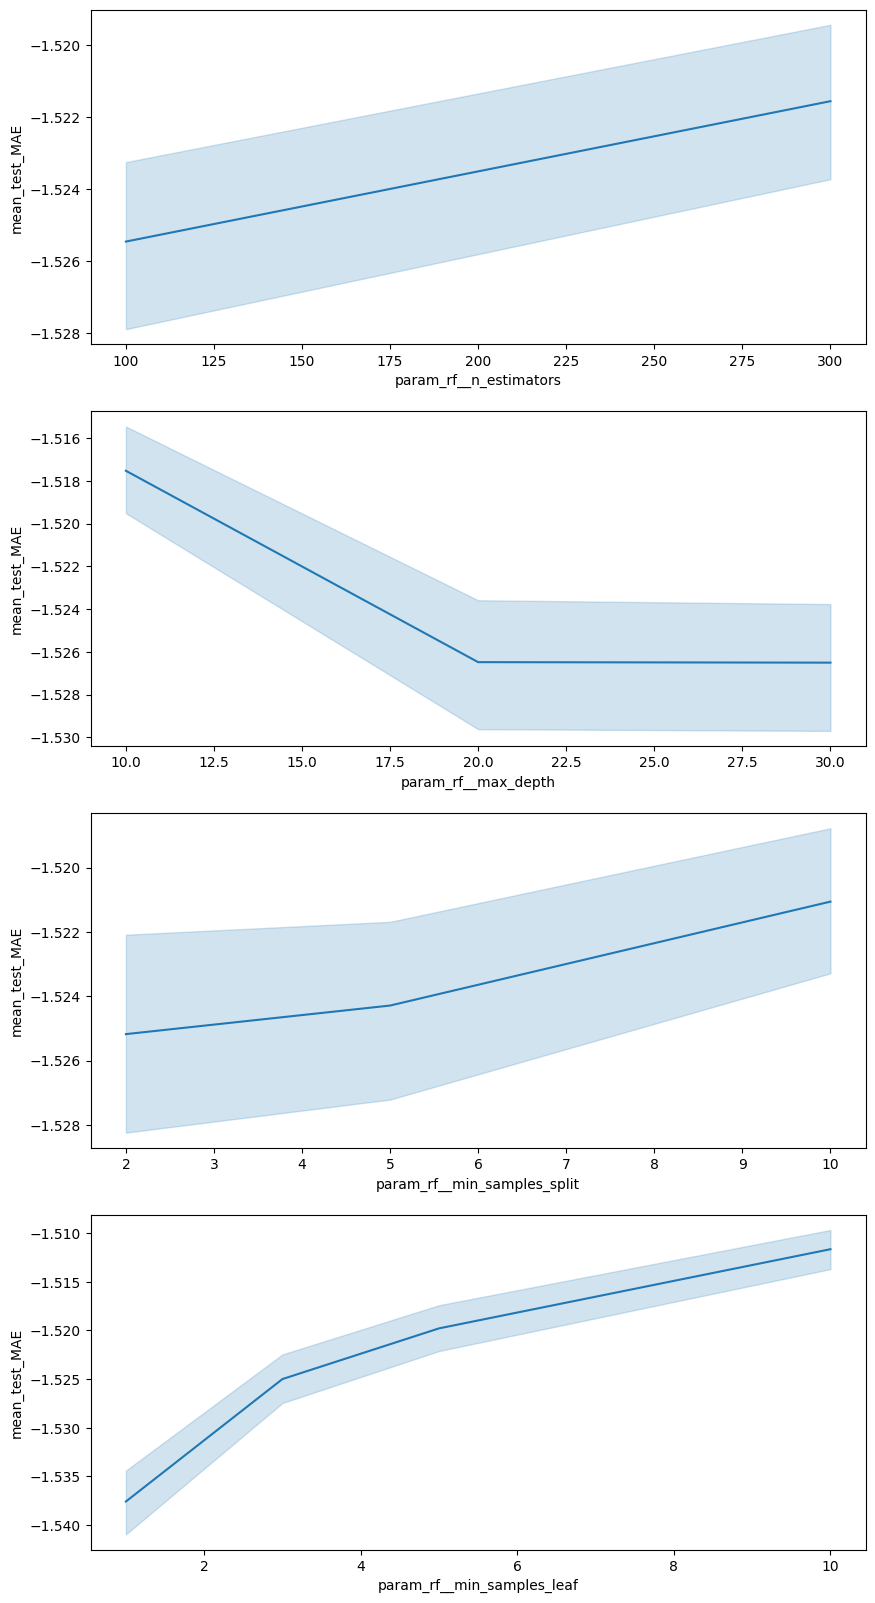

In [101]:
fig, ax = plt.subplots(4,1, figsize=(10, 20))
sb.lineplot(data=rf_cv_results, x='param_rf__n_estimators', y='mean_test_MAE', ax=ax[0])
sb.lineplot(data=rf_cv_results, x='param_rf__max_depth', y='mean_test_MAE', ax=ax[1])
sb.lineplot(data=rf_cv_results, x='param_rf__min_samples_split', y='mean_test_MAE', ax=ax[2])
sb.lineplot(data=rf_cv_results, x='param_rf__min_samples_leaf', y='mean_test_MAE', ax=ax[3])

En høyere verdi for antall estimators vil gjøre modellene i snitt litt bedre, noe som er forventet. Jeg velger derfor å teste et litt høyere antall. Trærne ser ut til å prestere bedre ved en lavere dybde, et høyere antall minimum samples for splitt, og et høyere antall minimum samples per bladnode.

### Random Forest; forbedret parametere

In [145]:
rf_params2 = {
    'rf__n_estimators': [300, 400],
    'rf__max_depth': [5, 8, 10, 15],
    'rf__min_samples_split': [8, 10, 15],
    'rf__min_samples_leaf': [5, 8, 10, 15]
}

In [146]:
rf_estimators2, rf_scores2, rf_cv_results2 = train(
    rf_pipe, 
    rf_params2,
    dataset_features,
    dataset_targets
    )
rf_scores2 = pd.DataFrame(rf_scores2)
rf_scores2.describe()

,MAE,MSE,RMSE,R2
count,5.000000,5.000000,5.000000,5.000000
mean,-1.499268,-4.576448,-2.138714,0.559579
std,0.043809,0.231867,0.054231,0.014776
min,-1.556762,-4.857482,-2.203970,0.540346
25%,-1.526023,-4.745645,-2.178450,0.548644
50%,-1.496523,-4.568179,-2.137330,0.565258
75%,-1.471295,-4.425140,-2.103602,0.566739
max,-1.445737,-4.285796,-2.070216,0.576908


<Axes: xlabel='param_rf__min_samples_leaf', ylabel='mean_test_MAE'>

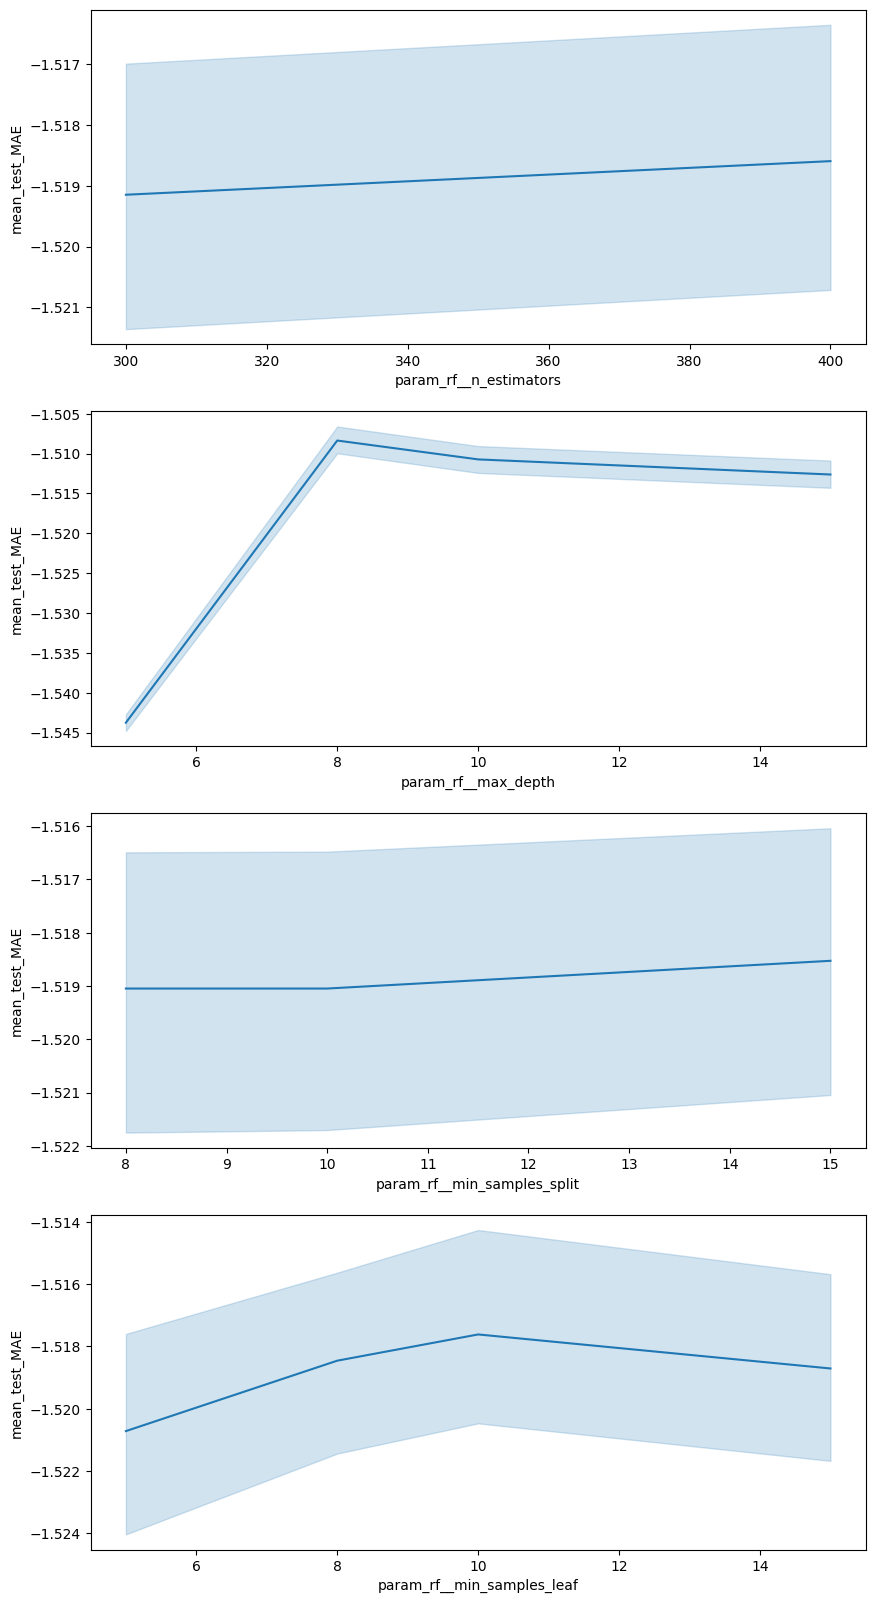

In [147]:
fig, ax = plt.subplots(4,1, figsize=(10, 20))
sb.lineplot(data=rf_cv_results2, x='param_rf__n_estimators', y='mean_test_MAE', ax=ax[0])
sb.lineplot(data=rf_cv_results2, x='param_rf__max_depth', y='mean_test_MAE', ax=ax[1])
sb.lineplot(data=rf_cv_results2, x='param_rf__min_samples_split', y='mean_test_MAE', ax=ax[2])
sb.lineplot(data=rf_cv_results2, x='param_rf__min_samples_leaf', y='mean_test_MAE', ax=ax[3])

Det er kun en liten økning fra 300-400 antall estimators, så jeg velger å sette den til 400 uten å teste høyere for at ikke treningstiden skal bli alt for høy. Ellers ser det ut til å være optimalt med rundt 8 i maksdybde, rundt 10-15 i minimum samples for splitt, og rundt 10 minimum samples per bladnode.

### Random Forest; Forbedret parametere

In [148]:
rf_params3 = {
    'rf__n_estimators': [400],
    'rf__max_depth': [6, 8, 10],
    'rf__min_samples_split': [10, 12, 15, 20],
    'rf__min_samples_leaf': [8, 10, 12]
}

In [149]:
rf_estimators3, rf_scores3, rf_cv_results3 = train(
    rf_pipe, 
    rf_params3,
    dataset_features,
    dataset_targets
    )
rf_scores3 = pd.DataFrame(rf_scores3)
rf_scores3.describe()

,MAE,MSE,RMSE,R2
count,5.000000,5.000000,5.000000,5.000000
mean,-1.499191,-4.558080,-2.134317,0.561379
std,0.044713,0.250916,0.058861,0.016477
min,-1.558403,-4.852170,-2.202764,0.540338
25%,-1.526732,-4.745727,-2.178469,0.549138
50%,-1.496110,-4.563670,-2.136275,0.567166
75%,-1.467906,-4.389783,-2.095181,0.568731
max,-1.446805,-4.239048,-2.058895,0.581523


<Axes: xlabel='param_rf__min_samples_leaf', ylabel='mean_test_MAE'>

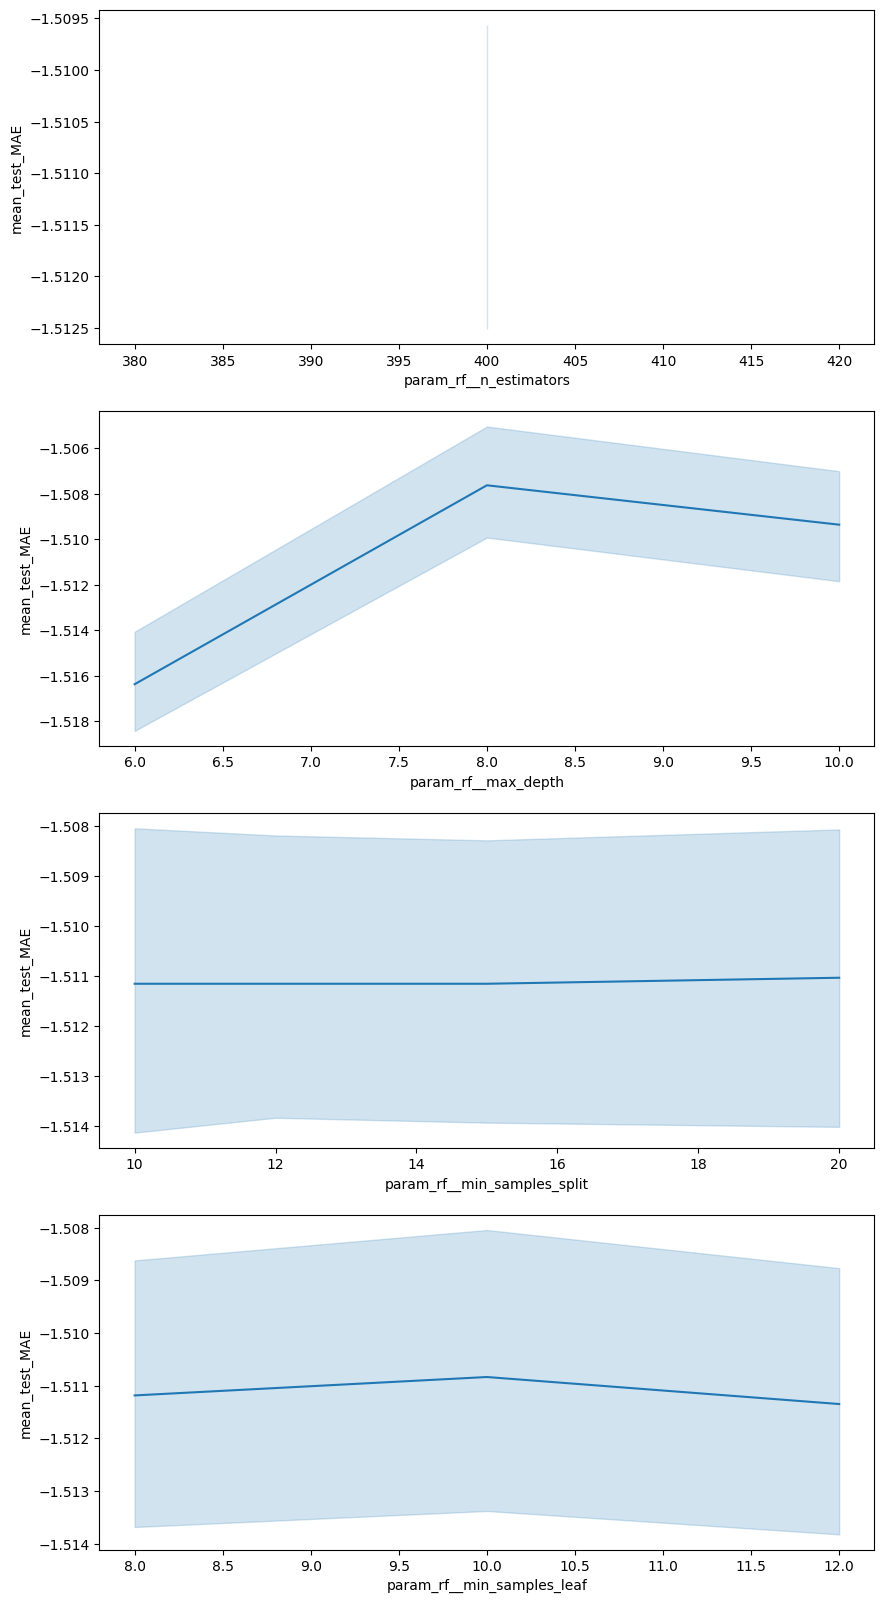

In [150]:
fig, ax = plt.subplots(4,1, figsize=(10, 20))
sb.lineplot(data=rf_cv_results3, x='param_rf__n_estimators', y='mean_test_MAE', ax=ax[0])
sb.lineplot(data=rf_cv_results3, x='param_rf__max_depth', y='mean_test_MAE', ax=ax[1])
sb.lineplot(data=rf_cv_results3, x='param_rf__min_samples_split', y='mean_test_MAE', ax=ax[2])
sb.lineplot(data=rf_cv_results3, x='param_rf__min_samples_leaf', y='mean_test_MAE', ax=ax[3])

Grafene viser at vi har funnet de beste parameterene.

In [151]:
columns = [
    'param_rf__n_estimators',
    'param_rf__max_depth',
    'param_rf__min_samples_split',
    'param_rf__min_samples_leaf',
    'mean_test_MAE'
]

rf_cv_results3_sorted = (
    rf_cv_results3[columns].groupby(['param_rf__n_estimators', 'param_rf__max_depth', 'param_rf__min_samples_split', 'param_rf__min_samples_leaf',],
        as_index=False)['mean_test_MAE'].mean().sort_values('mean_test_MAE', ascending=False)
)

rf_cv_results3_sorted.head()

,param_rf__n_estimators,param_rf__max_depth,param_rf__min_samples_split,param_rf__min_samples_leaf,mean_test_MAE
21,400,8,20,8,-1.507290
19,400,8,15,10,-1.507305
22,400,8,20,10,-1.507305
16,400,8,12,10,-1.507305
13,400,8,10,10,-1.507305


N-estimators er best på 400, max_depth er best på 8, min_samples_split på 20 og min_samples_leaf på 8. 

### Random Forest; endelige parametere

In [154]:
rf_params_final = {
    'rf__n_estimators': [400],
    'rf__max_depth': [8],
    'rf__min_samples_split': [20],
    'rf__min_samples_leaf': [8]
}

In [155]:
rf_estimators_final, rf_scores_final, rf_cv_results_final = train(
    rf_pipe, 
    rf_params_final,
    dataset_features,
    dataset_targets
    )
rf_scores_final = pd.DataFrame(rf_scores_final)
rf_scores_final.describe()

,MAE,MSE,RMSE,R2
count,5.000000,5.000000,5.000000,5.000000
mean,-1.498209,-4.558218,-2.134405,0.561341
std,0.046028,0.240126,0.056266,0.015777
min,-1.558403,-4.843506,-2.200797,0.540338
25%,-1.527553,-4.745727,-2.178469,0.549943
50%,-1.494221,-4.543987,-2.131663,0.568211
75%,-1.467978,-4.395082,-2.096445,0.569033
max,-1.442889,-4.262792,-2.064653,0.579179


### Gradient Boosting Regressor

In [156]:
gb_params = {
    'gb__n_estimators': [100, 300],
    'gb__learning_rate': [0.05, 0.1, 0.2],
    'gb__max_depth': [2, 3, 5],
    'gb__min_samples_split': [2, 5, 10],
    'gb__min_samples_leaf': [1, 3, 5, 10]
}

Jeg har valgt å tune 5 hyperparametere for Gradient Boosting Regressor med litt brede verdier som et utgangspunkt her også. Jeg har forsøkt å velge de mest relevante hyperparameterene for å kunne få best mulige resultater uten at kjøretiden blir for ekstrem.

N_estimators er antall trær som bygges. En lav verdi vil gi raskere kjøretid, men kan føre til at modellen underfitter dersom den ikke lærer nok av trærne. En høyere verdi vil gjøre modellen mer nøyaktig, men vil gjøre treningen tregere, samt kan føre til overfitting dersom learning rate er for høy.

Learning_rate er hvor mye hvert tre påvirker modellen. En lav verdi vil senke sannsynligheten for overfitting ettersom treningen blir mer stabil, men vil da trenge fler trær og kan bli tregere. En høyere verdi vil gjøre at modellen lærer raskere og det behøves færre trær, men det vil også bli mer sannsynlig med overfitting.

Max_depth er maksdybden et tre kan ha. En lavere verdi vil senke verdien for overfitting ettersom trærne blir mer generelle, men kan samtidig føre til at modellen underfitter om den ikke finner komplekse nok mønstre. En høyere verdi vil kunne la modellen finne fler komplekse mønstre, men kan fort føre til overfitting. Ettersom Gradient Boosting Regressor skal bygge mange svake trær for å lage en modell så er det hensiktsmessig å teste lavere verdier her enn for Random Forest Regressor.

Min_samples_split er hvor mange samples det må være i en node for at den skal splitte seg. En lav verdi vil kunne gjøre at modellen enklere fanger opp fler små detaljer, men kan føre til at trærne blir for dype og det blir overfitting. En høyere verdi vil senke sannsynligheten for overfitting ettersom den ikke ser etter like komplekse mønstre, samtidig så kan det føre til at den overser mønstre dersom verdien blir for høy.

Min_samples_leaf er hvor mange observasjoner som det minst skal være i en bladnode. En lav verdi vil gjøre at trærne kan finne mer komplekse mønstre, men vil øke sannsynligheten for overfitting. En høyere verdi vil redusere sannsynligheten for overfitting og trærne blir mer generelle, men kan føre til at modellen ikke finner nok detaljer.

In [157]:
gb_estimators, gb_scores, gb_cv_results = train(
    gb_pipe, 
    gb_params,
    dataset_features,
    dataset_targets
    )
gb_scores = pd.DataFrame(gb_scores)
gb_scores.describe()

,MAE,MSE,RMSE,R2
count,5.000000,5.000000,5.000000,5.000000
mean,-1.505135,-4.632312,-2.151724,0.554188
std,0.039150,0.237400,0.054722,0.015492
min,-1.549718,-5.001392,-2.236379,0.535272
25%,-1.540498,-4.722711,-2.173180,0.542567
50%,-1.495981,-4.531578,-2.128750,0.554801
75%,-1.482047,-4.510150,-2.123711,0.566056
max,-1.457430,-4.395726,-2.096599,0.572242


<Axes: xlabel='param_gb__min_samples_leaf', ylabel='mean_test_MAE'>

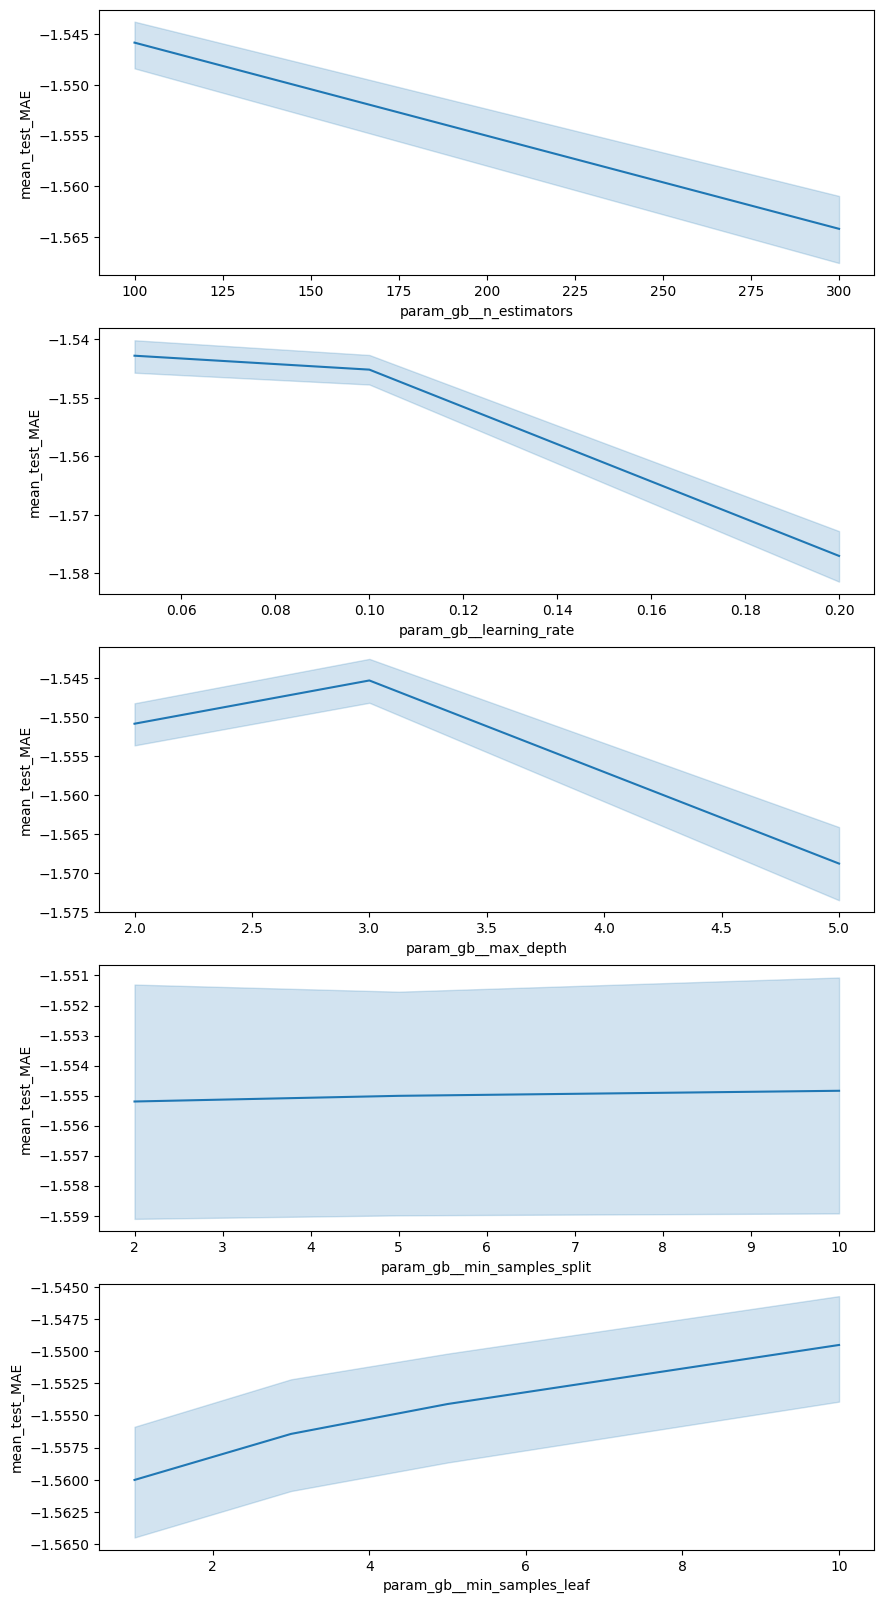

In [158]:
fig, ax = plt.subplots(5,1, figsize=(10, 20))
sb.lineplot(data=gb_cv_results, x='param_gb__n_estimators', y='mean_test_MAE', ax=ax[0])
sb.lineplot(data=gb_cv_results, x='param_gb__learning_rate', y='mean_test_MAE', ax=ax[1])
sb.lineplot(data=gb_cv_results, x='param_gb__max_depth', y='mean_test_MAE', ax=ax[2])
sb.lineplot(data=gb_cv_results, x='param_gb__min_samples_split', y='mean_test_MAE', ax=ax[3])
sb.lineplot(data=gb_cv_results, x='param_gb__min_samples_leaf', y='mean_test_MAE', ax=ax[4])

N_estimators fungerer bedre med et lavere antall, mulig at en for høy learning_rate også påvirker dette. Learning_rate ser ut til å fungere bedre på en lavere verdi. Max_depth er best rundt 3. Min_samples_split holder seg ganske jevn, øker minimalt ved en høyere verdi. Min_samples_leaf fungerer bedre på en høyere verdi.

### Gradient Boosting; forbedret parametere

In [114]:
gb_params2 = {
    'gb__n_estimators': [50, 100, 200],
    'gb__learning_rate': [0.01, 0.05, 0.1],
    'gb__max_depth': [2, 3, 4],
    'gb__min_samples_split': [5, 10, 15],
    'gb__min_samples_leaf': [8, 10, 15]
}

In [159]:
gb_estimators2, gb_scores2, gb_cv_results2 = train(
    gb_pipe, 
    gb_params2,
    dataset_features,
    dataset_targets
    )
gb_scores2 = pd.DataFrame(gb_scores2)
gb_scores2.describe()

,MAE,MSE,RMSE,R2
count,5.000000,5.000000,5.000000,5.000000
mean,-1.508783,-4.640276,-2.153562,0.553471
std,0.037776,0.239447,0.055298,0.014035
min,-1.547813,-4.990842,-2.234019,0.536252
25%,-1.543307,-4.747081,-2.178780,0.540207
50%,-1.512270,-4.617705,-2.148885,0.562042
75%,-1.472816,-4.423459,-2.103202,0.563433
max,-1.467707,-4.422294,-2.102925,0.565423


<Axes: xlabel='param_gb__min_samples_leaf', ylabel='mean_test_MAE'>

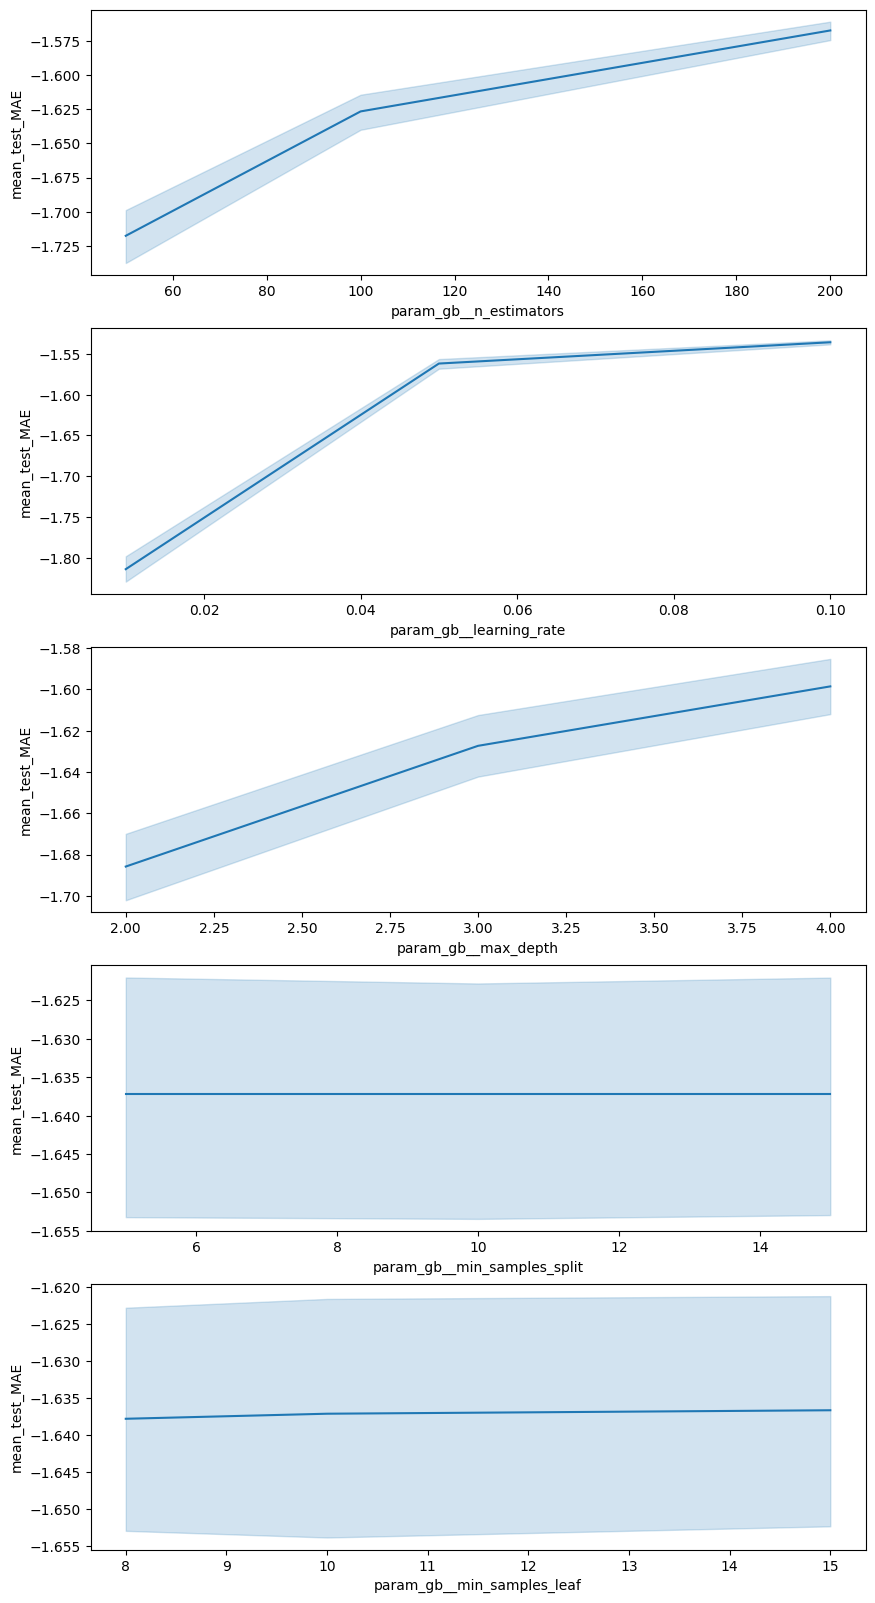

In [160]:
fig, ax = plt.subplots(5,1, figsize=(10, 20))
sb.lineplot(data=gb_cv_results2, x='param_gb__n_estimators', y='mean_test_MAE', ax=ax[0])
sb.lineplot(data=gb_cv_results2, x='param_gb__learning_rate', y='mean_test_MAE', ax=ax[1])
sb.lineplot(data=gb_cv_results2, x='param_gb__max_depth', y='mean_test_MAE', ax=ax[2])
sb.lineplot(data=gb_cv_results2, x='param_gb__min_samples_split', y='mean_test_MAE', ax=ax[3])
sb.lineplot(data=gb_cv_results2, x='param_gb__min_samples_leaf', y='mean_test_MAE', ax=ax[4])

N_estimators, learning_rate og max_depth ser ut til å stige litt ved en høyere verdi. Min_samples_split og min_samples_leaf holder seg relativt stabilt.

### Gradient Boosting; forbedret parametere

In [117]:
gb_params3 = {
    'gb__n_estimators': [100, 200, 300],
    'gb__learning_rate': [0.05, 0.1, 0.15],
    'gb__max_depth': [3, 4, 5],
    'gb__min_samples_split': [5, 10, 15],
    'gb__min_samples_leaf': [15, 20, 25]
}

In [161]:
gb_estimators3, gb_scores3, gb_cv_results3 = train(
    gb_pipe, 
    gb_params3,
    dataset_features,
    dataset_targets
    )
gb_scores3 = pd.DataFrame(gb_scores3)
gb_scores3.describe()

,MAE,MSE,RMSE,R2
count,5.000000,5.000000,5.000000,5.000000
mean,-1.499941,-4.594621,-2.142886,0.557850
std,0.040441,0.248596,0.057692,0.016165
min,-1.547813,-4.946713,-2.224121,0.540207
25%,-1.537184,-4.747081,-2.178780,0.540353
50%,-1.487823,-4.518710,-2.125726,0.566289
75%,-1.468552,-4.414646,-2.101106,0.570969
max,-1.458335,-4.345957,-2.084696,0.571431


<Axes: xlabel='param_gb__min_samples_leaf', ylabel='mean_test_MAE'>

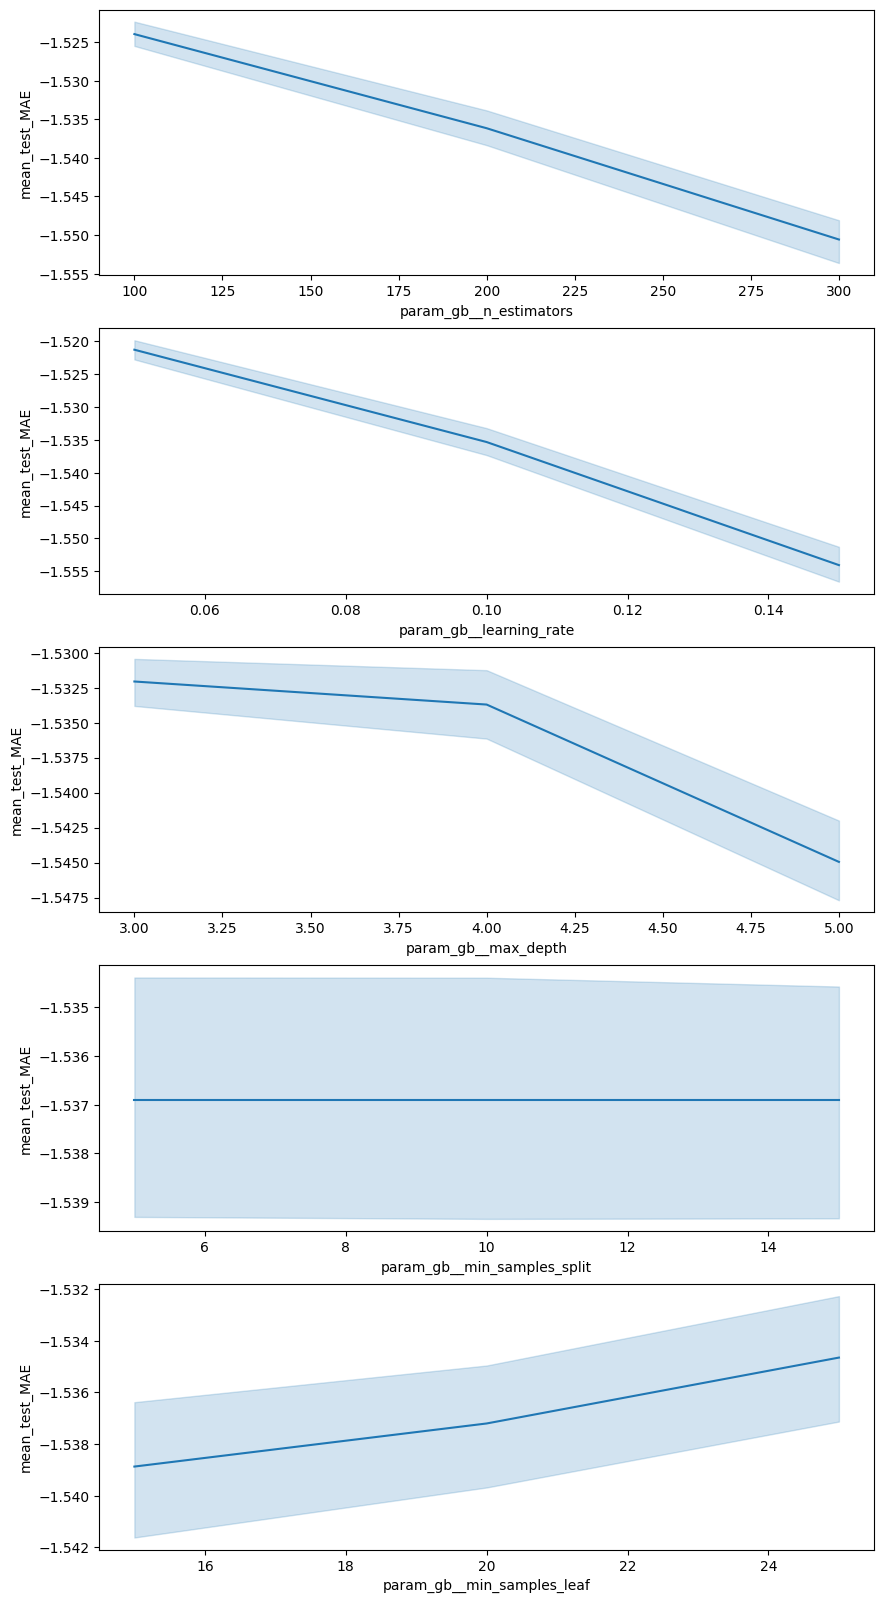

In [162]:
fig, ax = plt.subplots(5,1, figsize=(10, 20))
sb.lineplot(data=gb_cv_results3, x='param_gb__n_estimators', y='mean_test_MAE', ax=ax[0])
sb.lineplot(data=gb_cv_results3, x='param_gb__learning_rate', y='mean_test_MAE', ax=ax[1])
sb.lineplot(data=gb_cv_results3, x='param_gb__max_depth', y='mean_test_MAE', ax=ax[2])
sb.lineplot(data=gb_cv_results3, x='param_gb__min_samples_split', y='mean_test_MAE', ax=ax[3])
sb.lineplot(data=gb_cv_results3, x='param_gb__min_samples_leaf', y='mean_test_MAE', ax=ax[4])

Fjerner n_estimators på 300 ettersom det ikke presterer bra, og gjør treningstiden høy for videre tuning. Basert på grafene vil jeg teste enda litt høyere min_samples_leaf verdi.

### Gradient Boosting; forbedret parametere

In [120]:
gb_params4 = {
    'gb__n_estimators': [50, 100, 200],
    'gb__learning_rate': [0.01, 0.05, 0.1, 0.15],
    'gb__max_depth': [3, 4, 5],
    'gb__min_samples_split': [5, 10, 15],
    'gb__min_samples_leaf': [25, 30, 35, 40, 45]
}

In [163]:
gb_estimators4, gb_scores4, gb_cv_results4 = train(
    gb_pipe, 
    gb_params4,
    dataset_features,
    dataset_targets
    )
gb_scores4 = pd.DataFrame(gb_scores4)
gb_scores4.describe()

,MAE,MSE,RMSE,R2
count,5.000000,5.000000,5.000000,5.000000
mean,-1.502453,-4.584234,-2.140478,0.558835
std,0.044310,0.244490,0.056860,0.016162
min,-1.548820,-4.916662,-2.217355,0.539498
25%,-1.547905,-4.754398,-2.180458,0.543145
50%,-1.491167,-4.509974,-2.123670,0.567272
75%,-1.473752,-4.404643,-2.098724,0.572002
max,-1.450623,-4.335496,-2.082185,0.572259


<Axes: xlabel='param_gb__min_samples_leaf', ylabel='mean_test_MAE'>

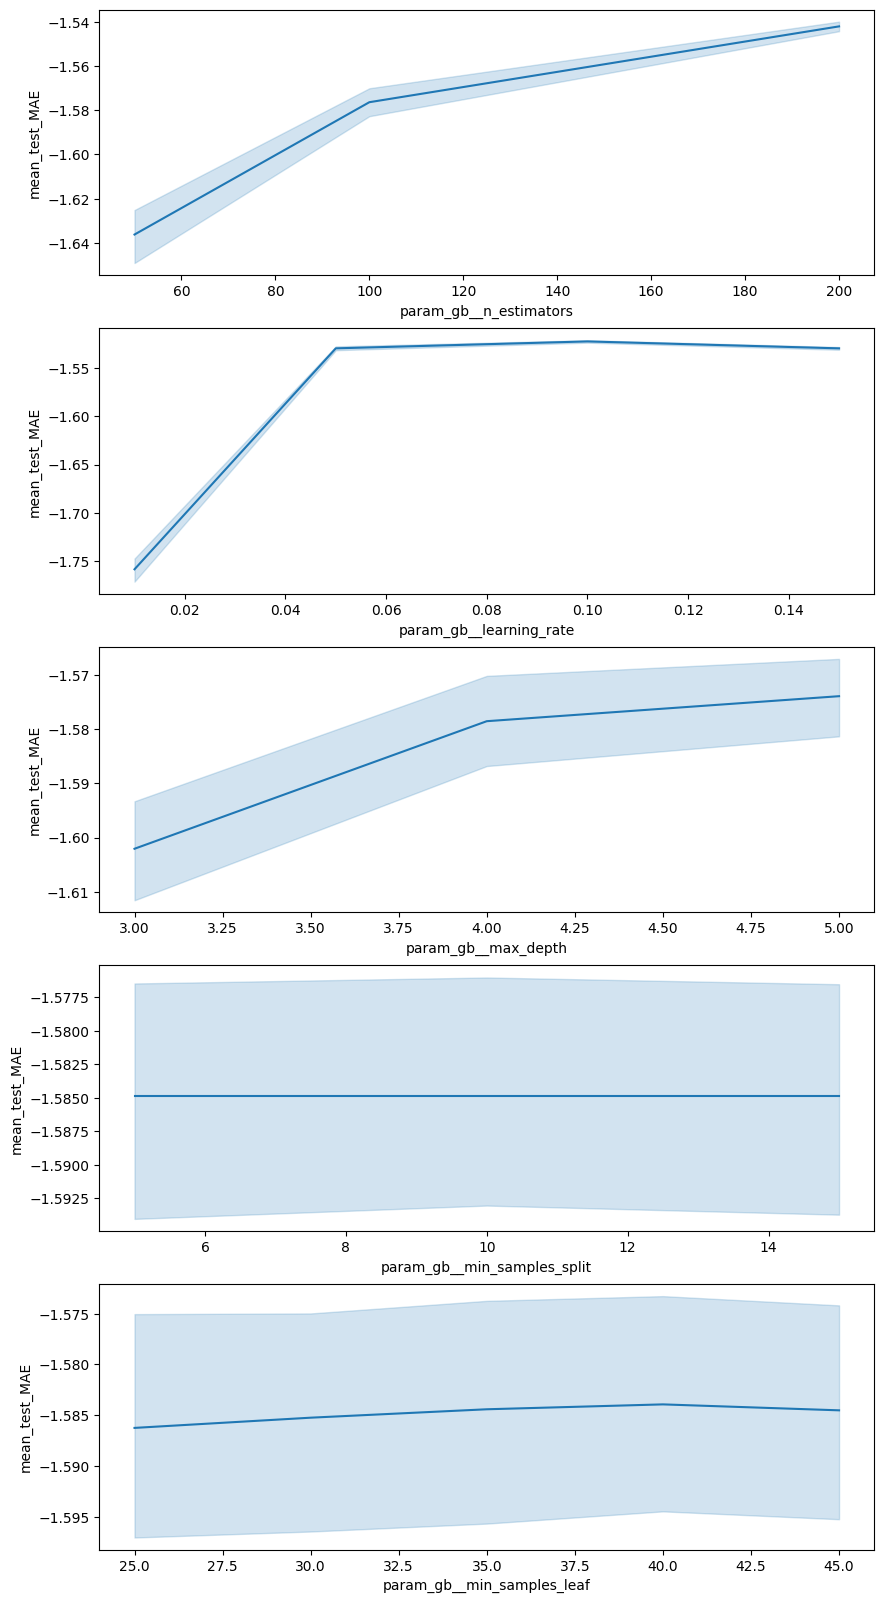

In [164]:
fig, ax = plt.subplots(5,1, figsize=(10, 20))
sb.lineplot(data=gb_cv_results4, x='param_gb__n_estimators', y='mean_test_MAE', ax=ax[0])
sb.lineplot(data=gb_cv_results4, x='param_gb__learning_rate', y='mean_test_MAE', ax=ax[1])
sb.lineplot(data=gb_cv_results4, x='param_gb__max_depth', y='mean_test_MAE', ax=ax[2])
sb.lineplot(data=gb_cv_results4, x='param_gb__min_samples_split', y='mean_test_MAE', ax=ax[3])
sb.lineplot(data=gb_cv_results4, x='param_gb__min_samples_leaf', y='mean_test_MAE', ax=ax[4])

Jeg har nå funnet omtrent de beste parameterene.

In [165]:
columns = [
    'param_gb__n_estimators',
    'param_gb__learning_rate',
    'param_gb__max_depth',
    'param_gb__min_samples_split',
    'param_gb__min_samples_leaf',
    'mean_test_MAE'
]

gb_cv_results4_sorted = (
    gb_cv_results4[columns].groupby(['param_gb__n_estimators', 'param_gb__learning_rate', 'param_gb__max_depth', 'param_gb__min_samples_split', 'param_gb__min_samples_leaf',],
        as_index=False)['mean_test_MAE'].mean().sort_values('mean_test_MAE', ascending=False)
)

gb_cv_results4_sorted.head()

,param_gb__n_estimators,param_gb__learning_rate,param_gb__max_depth,param_gb__min_samples_split,param_gb__min_samples_leaf,mean_test_MAE
267,100,0.05,5,15,35,-1.509397
257,100,0.05,5,5,35,-1.509397
262,100,0.05,5,10,35,-1.509397
268,100,0.05,5,15,40,-1.509966
258,100,0.05,5,5,40,-1.509966


De beste parameterene er n_estimators på 100, learning_rate på 0.05, max_depth på 5, min_samples_leaf på 35 og min_samples_split på 5-15.

### Gradient Boosting; endelige parametere

In [166]:
gb_params_final = {
    'gb__n_estimators': [100],
    'gb__learning_rate': [0.05],
    'gb__max_depth': [5],
    'gb__min_samples_split': [5],
    'gb__min_samples_leaf': [35]
}

In [167]:
gb_estimators_final, gb_scores_final, gb_cv_results_final = train(
    gb_pipe, 
    gb_params_final,
    dataset_features,
    dataset_targets
    )
gb_scores_final = pd.DataFrame(gb_scores_final)
gb_scores_final.describe()

,MAE,MSE,RMSE,R2
count,5.000000,5.000000,5.000000,5.000000
mean,-1.499837,-4.571722,-2.137663,0.560015
std,0.043398,0.221008,0.051470,0.013725
min,-1.548804,-4.883365,-2.209834,0.544372
25%,-1.540017,-4.704072,-2.168887,0.546239
50%,-1.491167,-4.509974,-2.123670,0.565311
75%,-1.469790,-4.424603,-2.103474,0.571893
max,-1.449405,-4.336596,-2.082449,0.572259


### MLP Regressor

In [209]:
mlp_params = {
    'mlp__hidden_layer_sizes': [(64,), (128,), (64,32), (128,64), (256,128)],
    'mlp__activation': ['relu', 'tanh'],
    'mlp__solver': ['adam'],
    'mlp__alpha': [0.00001, 0.0001, 0.001, 0.01],
    'mlp__learning_rate_init': [0.0005, 0.001, 0.005],
}

For MLP har jeg valgt 4 hyperparametere å tune, som bør være de som skal påvirke modellene mest. Jeg har startet med å teste brede verdier.

Hidden_layes_sizes bestemmer arkitekturen til det nevrale nettverket, nemlig hvor mange skjulte lag det skal ha og hvor mange nevroner hver lag har. Et lavt antall nevroner eller lag vil gjøre treningene raskere og minke sannsynligheten for overfitting, men kan samtidig føre til at modellen blir for enkel og presterer dårlig. Et høyere antall nevroner eller lag vil kunne få modellen til å fange opp mer komplekse mønstre, men kan føre til overfitting og vil utvide treningstiden.

Activation er aktiveringsfunksjonen som brukes i de skjulte lagene. Relu er standard og skal som regel fungere best, men på enkelte datasett kan tanh være bedre.

Alpha er verdien som bestemmer hvor mye modellen skal straffer store koeffisienter. En lav alpha vil kunne gjøre at modellen finner mer detaljer i dataen, men kan samtidig føre til overfitting. En høyere alpha vil minke sjansen for overfitting og gjøre modellen mer robust, men kan samtidig føre til at modellen ikke finner nok mønstre i dataen.

learning_rate_init bestemmer hvor mye modellen modellen justerer seg dersom vektene oppdaterer seg under trening. En lav verdi vil gjøre treningen mer stabil ettersom den er mer presis, men kan samtidig føre til en lang treningstid. En høyere verdi vil gjøre treningen raskere, men kan føre til at resultatene blir ustabile.

Jeg hadde egentlig også tenkt til å teste flere solvers, slik som lbfgs, men da trengte modellen fler enn 2000 iterasjoner, og treningen tok  svært lang tid.

In [210]:
mlp_estimators, mlp_scores, mlp_cv_results = train(
    mlp_pipe, 
    mlp_params,
    dataset_features,
    dataset_targets
    )
mlp_scores = pd.DataFrame(mlp_scores) 
mlp_scores.describe()

,MAE,MSE,RMSE,R2
count,5.000000,5.000000,5.000000,5.000000
mean,-1.486687,-4.339459,-2.082994,0.582139
std,0.030327,0.113895,0.027319,0.011243
min,-1.533678,-4.499397,-2.121178,0.564197
25%,-1.492683,-4.378177,-2.092409,0.579017
50%,-1.482757,-4.342959,-2.083977,0.586200
75%,-1.472555,-4.285092,-2.070046,0.588099
max,-1.451763,-4.191671,-2.047357,0.593181


<Axes: xlabel='param_mlp__learning_rate_init', ylabel='mean_test_MAE'>

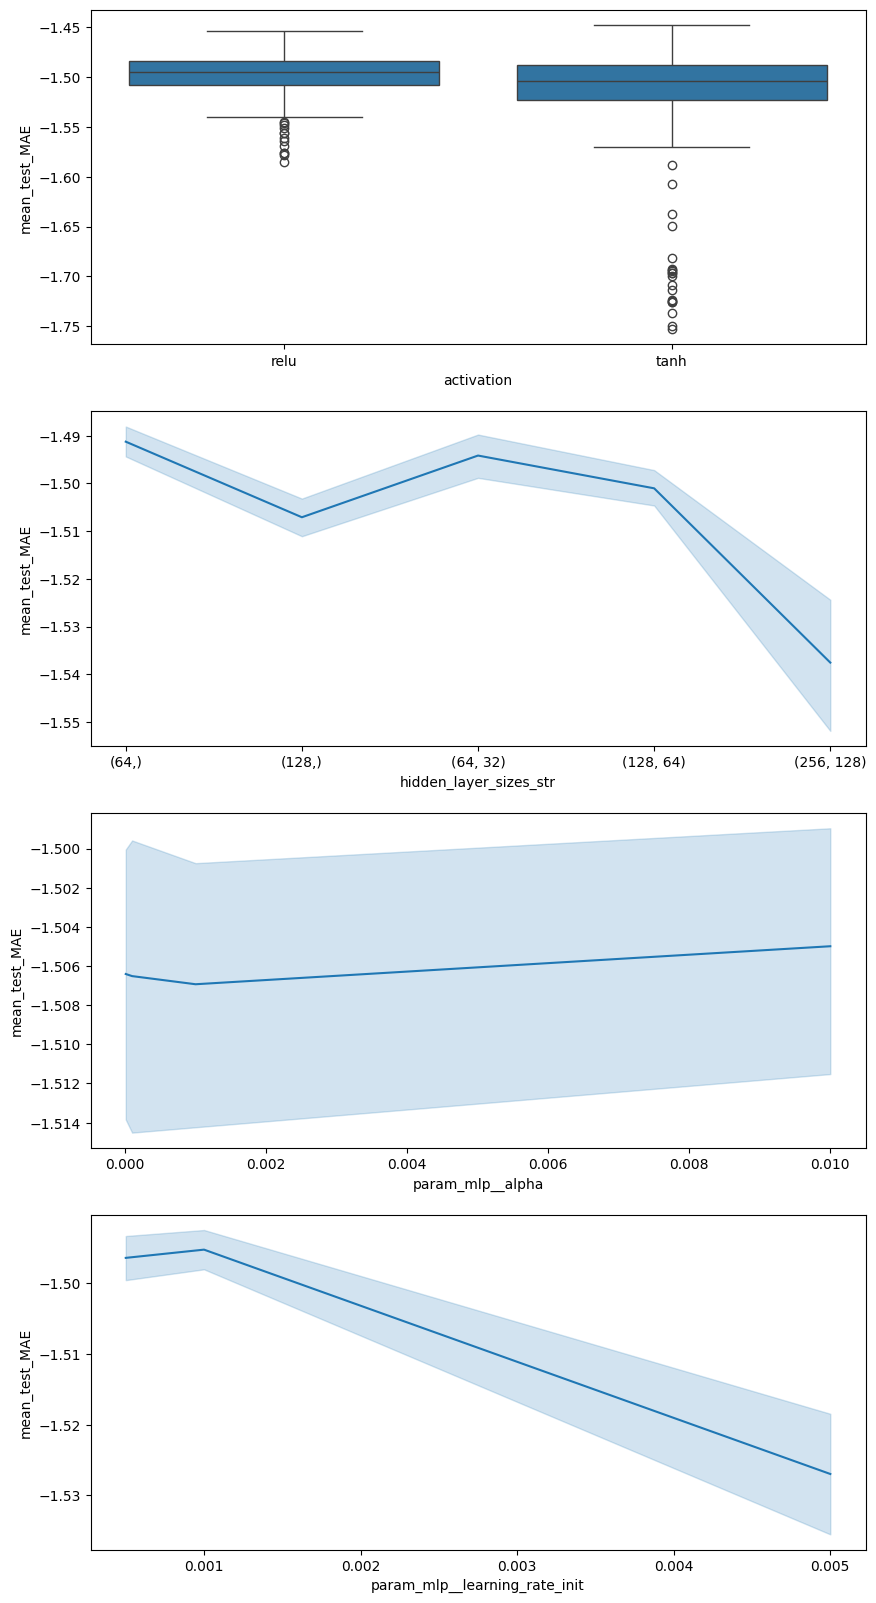

In [211]:
mlp_cv_results_plot = mlp_cv_results.copy()
mlp_cv_results_plot['activation'] = mlp_cv_results_plot['param_mlp__activation'].fillna('None').astype(str)

mlp_cv_results_plot['hidden_layer_sizes_str'] = (mlp_cv_results_plot['param_mlp__hidden_layer_sizes'].astype(str))

fig, ax = plt.subplots(4,1, figsize=(10, 20))
sb.boxplot(data=mlp_cv_results_plot, x='activation', y='mean_test_MAE', ax=ax[0])
sb.lineplot(data=mlp_cv_results_plot, x='hidden_layer_sizes_str', y='mean_test_MAE', ax=ax[1])
sb.lineplot(data=mlp_cv_results_plot, x='param_mlp__alpha', y='mean_test_MAE', ax=ax[2])
sb.lineplot(data=mlp_cv_results_plot, x='param_mlp__learning_rate_init', y='mean_test_MAE', ax=ax[3])

Fra grafene ser det ut som at relu presterer litt bedre enn tanh, hidden layer_sizes ser best ut med ett lite lag, alpha kan fungere godt på lavere og høyere verdier, men learning rate klart fungerer bedre på lavere verdi.

### MLP; forbedret parametere

In [212]:
mlp_params2 = {
    'mlp__hidden_layer_sizes': [(32,), (48,), (64,), (128,), (64,32)],
    'mlp__activation': ['relu', 'tanh'],
    'mlp__solver': ['adam'],
    'mlp__alpha': [0.00001, 0.0001, 0.001, 0.01],
    'mlp__learning_rate_init': [0.0005, 0.001, 0.003],
}

In [213]:
mlp_estimators2, mlp_scores2, mlp_cv_results2 = train(
    mlp_pipe, 
    mlp_params2,
    dataset_features,
    dataset_targets
    )
mlp_scores2 = pd.DataFrame(mlp_scores2) 
mlp_scores2.describe()

,MAE,MSE,RMSE,R2
count,5.000000,5.000000,5.000000,5.000000
mean,-1.478769,-4.320180,-2.078194,0.584014
std,0.036751,0.166989,0.040123,0.015745
min,-1.540854,-4.558695,-2.135110,0.558453
25%,-1.482757,-4.378177,-2.092409,0.579017
50%,-1.463679,-4.285092,-2.070046,0.593181
75%,-1.454792,-4.278590,-2.068475,0.594204
max,-1.451763,-4.100344,-2.024931,0.595216


<Axes: xlabel='param_mlp__learning_rate_init', ylabel='mean_test_MAE'>

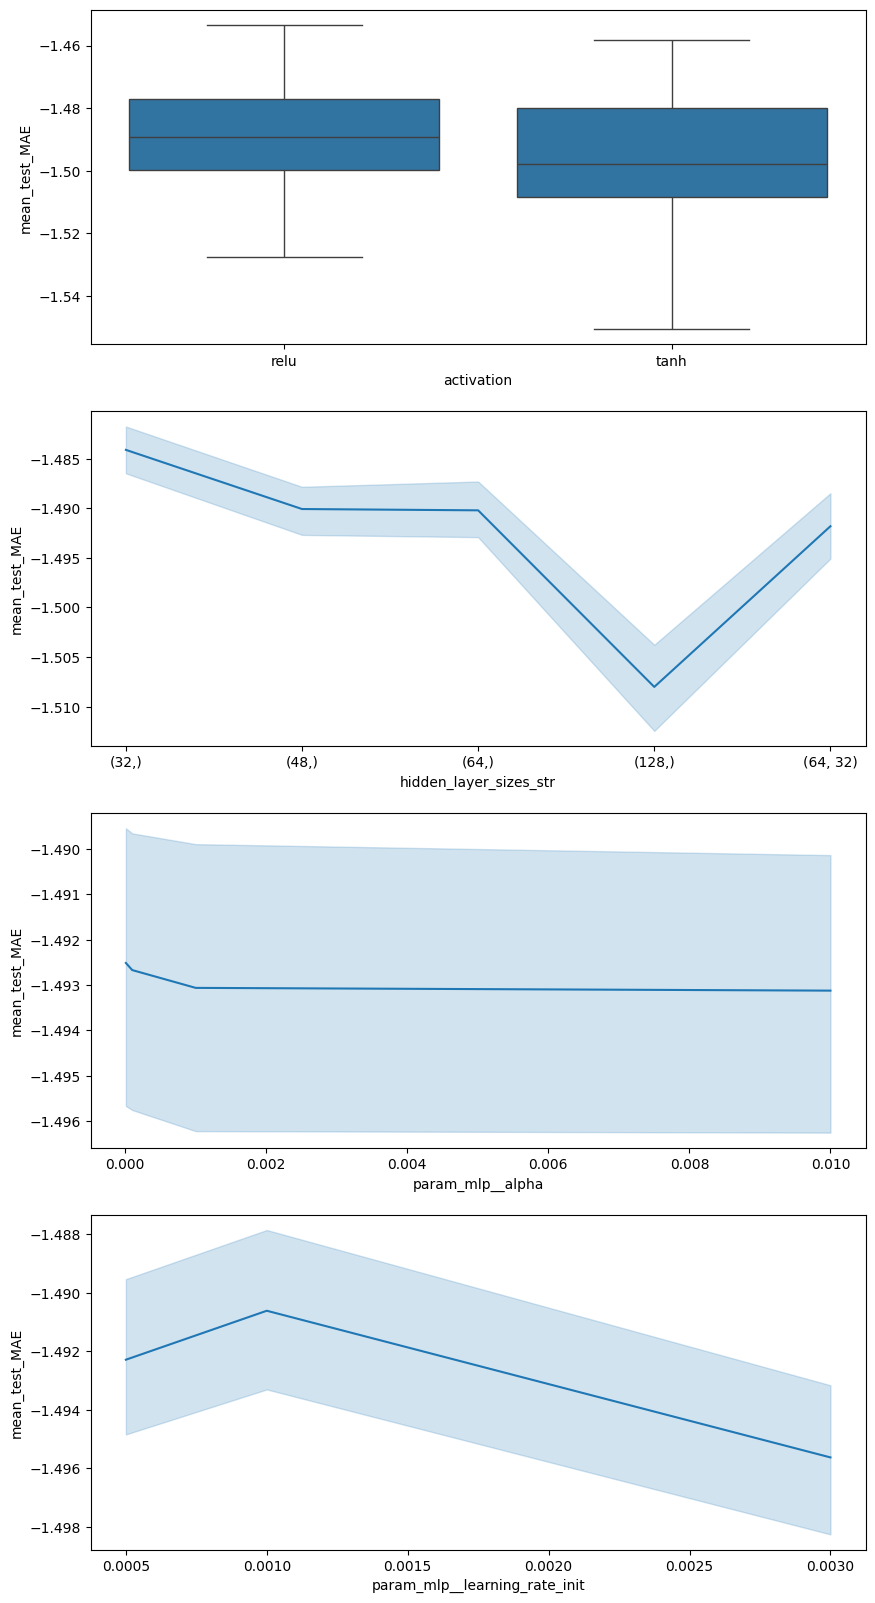

In [214]:
mlp_cv_results_plot2 = mlp_cv_results2.copy()
mlp_cv_results_plot2['activation'] = mlp_cv_results_plot2['param_mlp__activation'].fillna('None').astype(str)

mlp_cv_results_plot2['hidden_layer_sizes_str'] = (mlp_cv_results_plot2['param_mlp__hidden_layer_sizes'].astype(str))

fig, ax = plt.subplots(4,1, figsize=(10, 20))
sb.boxplot(data=mlp_cv_results_plot2, x='activation', y='mean_test_MAE', ax=ax[0])
sb.lineplot(data=mlp_cv_results_plot2, x='hidden_layer_sizes_str', y='mean_test_MAE', ax=ax[1])
sb.lineplot(data=mlp_cv_results_plot2, x='param_mlp__alpha', y='mean_test_MAE', ax=ax[2])
sb.lineplot(data=mlp_cv_results_plot2, x='param_mlp__learning_rate_init', y='mean_test_MAE', ax=ax[3])

relu, ett mindre lag, en lavere alpha verdi og en learning rate på rundt 0.001 ser ut til å være best.

### MLP; forbedret parametere

In [216]:
mlp_params3 = {
    'mlp__hidden_layer_sizes': [(16,), (24,), (32,), (48,), (64,)],
    'mlp__activation': ['relu', 'tanh'],
    'mlp__solver': ['adam'],
    'mlp__alpha': [0.00001, 0.0001, 0.001],
    'mlp__learning_rate_init': [0.0005, 0.001, 0.003],
}

In [217]:
mlp_estimators3, mlp_scores3, mlp_cv_results3 = train(
    mlp_pipe, 
    mlp_params3,
    dataset_features,
    dataset_targets
    )
mlp_scores3 = pd.DataFrame(mlp_scores3) 
mlp_scores3.describe()

,MAE,MSE,RMSE,R2
count,5.000000,5.000000,5.000000,5.000000
mean,-1.477556,-4.362437,-2.088242,0.580026
std,0.044218,0.190740,0.045866,0.015578
min,-1.540854,-4.558695,-2.135110,0.558453
25%,-1.495297,-4.520331,-2.126107,0.572151
50%,-1.478919,-4.354981,-2.086859,0.579972
75%,-1.443510,-4.293796,-2.072148,0.592762
max,-1.429199,-4.084385,-2.020986,0.596791


<Axes: xlabel='param_mlp__learning_rate_init', ylabel='mean_test_MAE'>

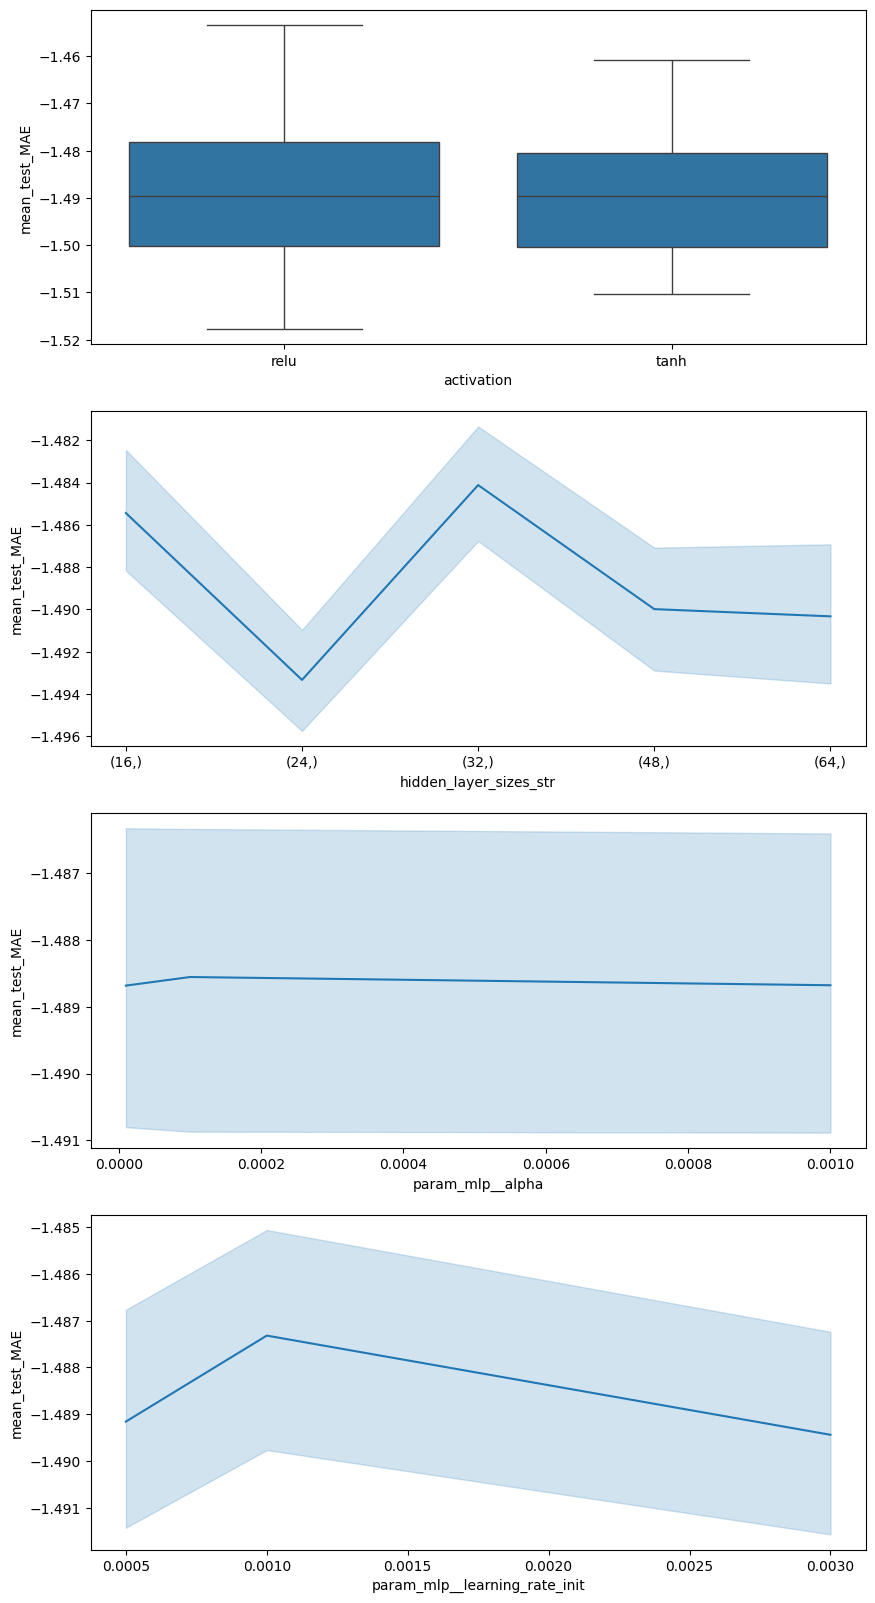

In [218]:
mlp_cv_results_plot3 = mlp_cv_results3.copy()
mlp_cv_results_plot3['activation'] = mlp_cv_results_plot3['param_mlp__activation'].fillna('None').astype(str)

mlp_cv_results_plot3['hidden_layer_sizes_str'] = (mlp_cv_results_plot3['param_mlp__hidden_layer_sizes'].astype(str))

fig, ax = plt.subplots(4,1, figsize=(10, 20))
sb.boxplot(data=mlp_cv_results_plot3, x='activation', y='mean_test_MAE', ax=ax[0])
sb.lineplot(data=mlp_cv_results_plot3, x='hidden_layer_sizes_str', y='mean_test_MAE', ax=ax[1])
sb.lineplot(data=mlp_cv_results_plot3, x='param_mlp__alpha', y='mean_test_MAE', ax=ax[2])
sb.lineplot(data=mlp_cv_results_plot3, x='param_mlp__learning_rate_init', y='mean_test_MAE', ax=ax[3])

Det ser nå ut til at jeg har funnet de omtrent beste parameterene.

In [220]:
columns = [
    'param_mlp__hidden_layer_sizes',
    'param_mlp__activation',
    'param_mlp__alpha',
    'param_mlp__learning_rate_init',
    'mean_test_MAE'
]

mlp_cv_results3_sorted = (
    mlp_cv_results3[columns].groupby(['param_mlp__hidden_layer_sizes', 'param_mlp__activation', 'param_mlp__alpha', 'param_mlp__learning_rate_init'],
        as_index=False)['mean_test_MAE'].mean().sort_values('mean_test_MAE', ascending=False)
)

mlp_cv_results3_sorted.head()

,param_mlp__hidden_layer_sizes,param_mlp__activation,param_mlp__alpha,param_mlp__learning_rate_init,mean_test_MAE
40,"(32,)",relu,0.00010,0.0010,-1.479669
75,"(64,)",relu,0.00010,0.0005,-1.480171
37,"(32,)",relu,0.00001,0.0010,-1.480274
43,"(32,)",relu,0.00100,0.0010,-1.480278
72,"(64,)",relu,0.00001,0.0005,-1.480485


De beste parameterene er ett lag med 32 nevroner, relu, 0.0001 i alpha-verdi og 0.001 i learning rate.

### MLP; endelige parametere

In [221]:
mlp_params_final = {
    'mlp__hidden_layer_sizes': [(32,)],
    'mlp__activation': ['relu'],
    'mlp__solver': ['adam'],
    'mlp__alpha': [0.0001],
    'mlp__learning_rate_init': [0.001]
}

In [222]:
mlp_estimators_final, mlp_scores_final, mlp_cv_results_final = train(
    mlp_pipe, 
    mlp_params_final,
    dataset_features,
    dataset_targets
    )
mlp_scores_final = pd.DataFrame(mlp_scores_final) 
mlp_scores_final.describe()

,MAE,MSE,RMSE,R2
count,5.000000,5.000000,5.000000,5.000000
mean,-1.473311,-4.293945,-2.071807,0.586563
std,0.045493,0.183210,0.044164,0.016689
min,-1.536739,-4.552961,-2.133767,0.559009
25%,-1.501165,-4.362822,-2.088737,0.582855
50%,-1.460179,-4.256286,-2.063077,0.594608
75%,-1.445488,-4.246023,-2.060588,0.596320
max,-1.422982,-4.051631,-2.012866,0.600025


### Keras Regressor

## Sammenligning av resultater og konklusjon

In [223]:
training_results = pd.DataFrame({
    'Metric' : ['MAE', 'MSE', 'RMSE', "R2"],
    'LR' : [-lr_scores_final['MAE'].mean(), -lr_scores_final['MSE'].mean(), -lr_scores_final['RMSE'].mean(), lr_scores_final['R2'].mean()],
    'RI' : [-ri_scores_final['MAE'].mean(), -ri_scores_final['MSE'].mean(), -ri_scores_final['RMSE'].mean(), ri_scores_final['R2'].mean()],
    'RF' : [-rf_scores_final['MAE'].mean(), -rf_scores_final['MSE'].mean(), -rf_scores_final['RMSE'].mean(), rf_scores_final['R2'].mean()],
    'GB' : [-gb_scores_final['MAE'].mean(), -gb_scores_final['MSE'].mean(), -gb_scores_final['RMSE'].mean(), gb_scores_final['R2'].mean()],
    'MLP' : [-mlp_scores_final['MAE'].mean(), -mlp_scores_final['MSE'].mean(), -mlp_scores_final['RMSE'].mean(), mlp_scores_final['R2'].mean()]
})
training_results.set_index('Metric', inplace=True)
training_results

,LR,RI,RF,GB,MLP
Metric,,,,,
MAE,1.551099,1.551089,1.498209,1.499837,1.473311
MSE,4.658587,4.658567,4.558218,4.571722,4.293945
RMSE,2.157539,2.157534,2.134405,2.137663,2.071807
R2,0.551627,0.551630,0.561341,0.560015,0.586563


Kilder:
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor
https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html
https://adriangb.com/scikeras/stable/generated/scikeras.wrappers.KerasRegressor.html